# Practical, methodological and theoretical grounds

## Data 

### Simulation

We will start by simulating data to demonstrate the HMP analysis on simulated data.
First, we need to load several libraries, after which we simulate a dataset with 4 events and the resulting 5 inter-event times (stimulus -> event 1, event 1 -> event 2, ..., event 4 -> response.

In [1]:
## Importing these packages is specific for this simulation case
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma

import xarray as xr
from mne.io import read_info

## Importing HMP
import hmp
from hmp import simulations

cpus = 5 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM
import multiprocessing as mp
#When using multiple CPUs explicitely setting the context of the multiprocessing is needed
#The following line works in most environment
mp.set_start_method("spawn")
#If multiprocessing errors/warning still present comment previous line and uncomment this one

## Running the demo function in the simulation module
# Inspect the given function to apply your own simulations
from hmp.simulations import demo

In [2]:


n_trials = 100 #Number of trials to simulate
sfreq = 500
##### Here we define the sources of the brain activity (event) for each trial
n_events = 4
frequency = 10. #Frequency of the event defining its duration, half-sine of 10Hz = 50ms
amplitude = 2.5e-7 #Amplitude of the event in nAm, defining signal to noise ratio
shape = 2 #shape of the gamma distribution
means = np.array([60, 150, 200, 100, 80])/shape #Mean duration of the between event times in ms
names = ['inferiortemporal-lh','caudalanteriorcingulate-rh','bankssts-lh','superiorparietal-lh','superiorparietal-lh']#Which source to activate for each event (see atlas when calling simulations.available_sources())

sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, 'dataset_raw', overwrite=False, sfreq=sfreq, seed=1)
#load electrode position, specific to the simulations
positions = simulations.simulation_positions()

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:191: UserWarning: ./dataset_raw_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


Next, we load the simulated data, reflecting a realistic EEG dataset of a single participant. As you can see, we use standard MNE functions here.

In [3]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}
#Keeping only stimulus and response triggers


#Visualising the raw simulated EEG data
import mne
raw = mne.io.read_raw_fif(file[0], preload=False, verbose=False)
raw.pick_types(eeg=True).plot(scalings=dict(eeg=1e-5), events=events, block=True);


### Data Format 
We now prepare the data for the HMP package. First, we read the data into an xarray.

In [4]:
# Reading the data
eeg_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)
eeg_data

Processing participant ./dataset_raw_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/main_hmp/lib/python3.12/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


100 trials were retained for participant ./dataset_raw_raw.fif


<xarray.Dataset> Size: 34MB
Dimensions:      (participant: 1, epochs: 100, channels: 59, samples: 719)
Coordinates:
  * epochs       (epochs) int64 800B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * channels     (channels) <U7 2kB 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * samples      (samples) int64 6kB 0 1 2 3 4 5 6 ... 713 714 715 716 717 718
    event_name   (epochs) object 800B 'stimulus' 'stimulus' ... 'stimulus'
    rt           (epochs) float64 800B 0.28 0.432 0.718 ... 0.806 0.316 0.83
  * participant  (participant) <U2 8B 'S0'
Data variables:
    data         (participant, epochs, channels, samples) float64 34MB -1.203...
Attributes:
    sfreq:           500.0
    offset:          0
    lowpass:         40.0
    highpass:        0.10000000149011612
    lower_limit_RT:  0
    upper_limit_RT:  5.002

The previous function epochs the data, cut the EEG data at each RT value and stores any additional infomation along (here 'event_name').

xarray is a handy way of using matrices with named dimensions. For example we can now very easily draw an ERP:


<xarray.Dataset> Size: 34MB
Dimensions:      (participant: 1, epochs: 100, channels: 59, samples: 719)
Coordinates:
  * epochs       (epochs) int64 800B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * channels     (channels) <U7 2kB 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * samples      (samples) int64 6kB 0 1 2 3 4 5 6 ... 713 714 715 716 717 718
    event_name   (epochs) object 800B 'stimulus' 'stimulus' ... 'stimulus'
    rt           (epochs) float64 800B 0.28 0.432 0.718 ... 0.806 0.316 0.83
  * participant  (participant) <U2 8B 'S0'
Data variables:
    data         (participant, epochs, channels, samples) float64 34MB -1.203...
Attributes:
    sfreq:           500.0
    offset:          0
    lowpass:         40.0
    highpass:        0.10000000149011612
    lower_limit_RT:  0
    upper_limit_RT:  5.002


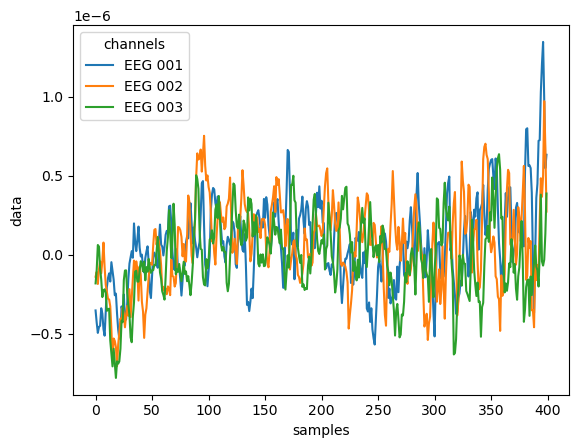

In [5]:
#example of usage of xarray
print(eeg_data)
eeg_data.sel(channels=['EEG 001','EEG 002','EEG 003'], samples=range(400))\
    .data.groupby('samples').mean(['participant','epochs']).plot.line(hue='channels')
plt.show()

Next, we transform the data for HMP:
- Apply PCA and select top components to lower computational load
- zscore the data per trial

This analysis step asks you to choose a number of PC components; 4 is a reasonable answer based on the 'elbow method' (more on this in Tutorial 3).

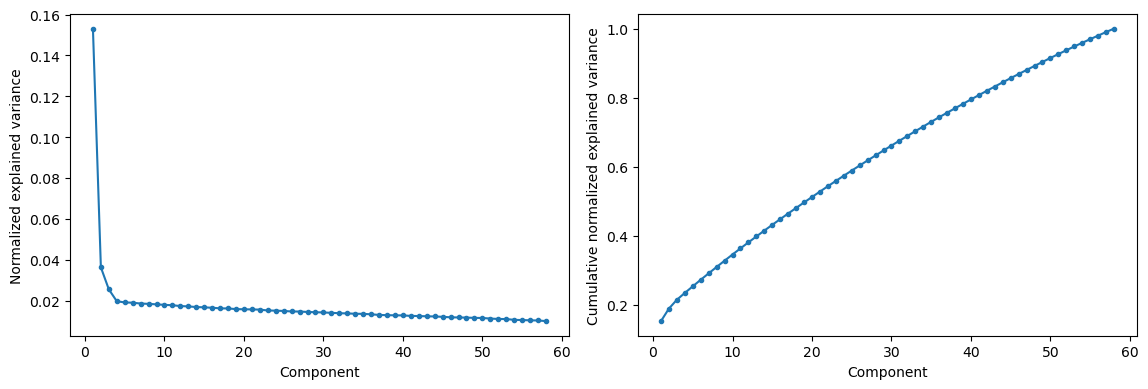

How many PCs (95 and 99% explained variance at component n54 and n57; components till n57 explain at least 1%)? 4


In [6]:
hmp_data = hmp.utils.transform_data(eeg_data, apply_standard=False)

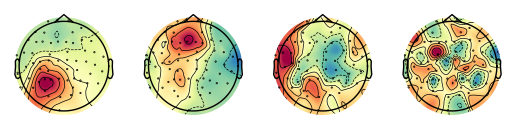

In [7]:
hmp.visu.plot_components_sensor(hmp_data, positions)

## HMP and implementation assumptions

HMP uses classes to instantiate fit of hmp models. Therefore before estimating a model one needs to declare an instance of the hmp class by specifying the data, the sampling frequency of the data as well as several parmeters such as the target event width (in milliseconds) and the expected distribution (both family and shape).

By default, we use the same assumptions for the events and between events time distributions as in the original paper of Anderson, Zhang, Borst & Walsh, 2016. That is, we use an event template of a half sine wave and gamma distributions with a shape parameter of 2 to model the data. Note that you can very easily use other templates and distributions in HMP.

In the next step, we initialize an hmp model 'init' with those standard settings, using the data we simulated above.

In [8]:
init = hmp.models.hmp(data=hmp_data, epoch_data=eeg_data, sfreq=eeg_data.sfreq,
                      event_width=50, distribution='gamma', shape=2)

We can view the template used by init: a 50 ms bump (i.e. a 10Hz half-sin):

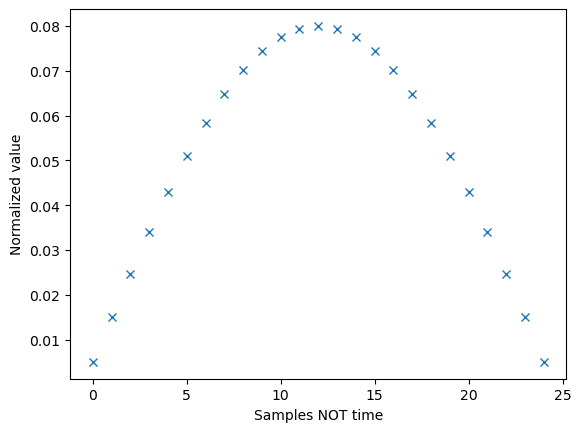

In [9]:
plt.plot(init.template, 'x')
plt.ylabel('Normalized value')
plt.xlabel('Samples NOT time')
plt.show()

When calling ```hmp.models.hmp```, the function automatically cross-correlated the data with the provided template, to get an estimate of where the EEG data looks like the template.

Below, we plot those cross-correlated values; the vertical lines indicate the start of the events in the simulated data.

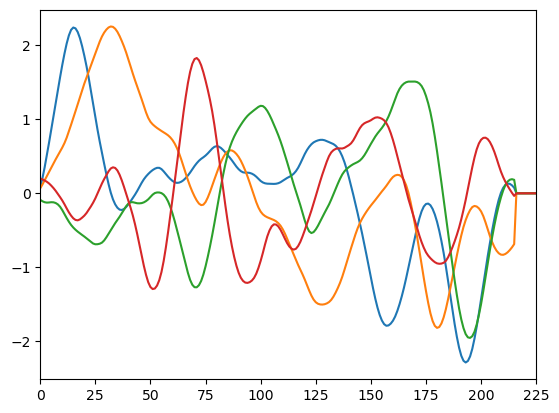

In [10]:
plt.plot(init.data_matrix[:,1,:])

#Recover the actual time of the simulated events
sim_source_times = np.reshape(np.ediff1d(events[:,1],to_begin=0)[events[:,2] > 1], (n_trials, n_events+1))
plt.vlines(sim_source_times[1,:-1].cumsum()-1, -.5, .5, 'k') #overlaying the simulated event onset times
plt.xlim(0,225)
plt.show()

### HMP parameters

An HMP model tries to recover the underlying magnitudes (= EEG/MEG topologies) and inter-event time distribution parameters from the data. Here, we first we retrieve the actual generating parameters from the simulation, in order to judge how well the HMP recovery works.

In [11]:
sim_source_times, true_pars, true_magnitudes, _ = simulations.simulated_times_and_parameters(events, init)

As an exceedingly simple example, we will first feed these parameters and magnitudes into the HMP model fitting procedure as starting points, and try to estimate a model.

We do that by calling `fit_single` on `init`, and telling it to recover 4 events and using the true parameters and magnitudes as starting points. We also tell it that it does not in fact have to maximize the fit.

Estimating 4 events model
parameters estimated for 4 events model


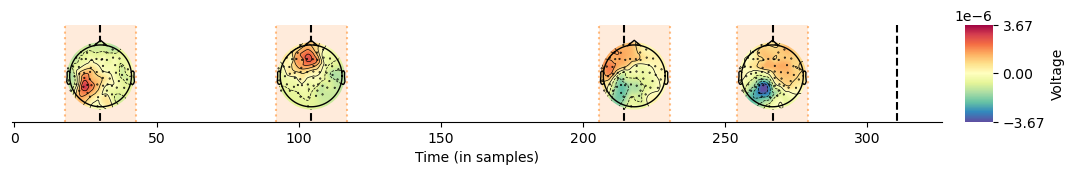

In [12]:
estimates = init.fit_single(n_events, parameters = true_pars, magnitudes=true_magnitudes, maximization=False)

hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, magnify=1, sensors=True, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

In the plot above we see the four recovered events; the vertical lines again indicate the start of the actual events. Not surprisingly, the recovery is perfect.

The first element that we fed into the fit_single function were the expected distributions for between event duration, `true_pars`. Let's have a look at those:

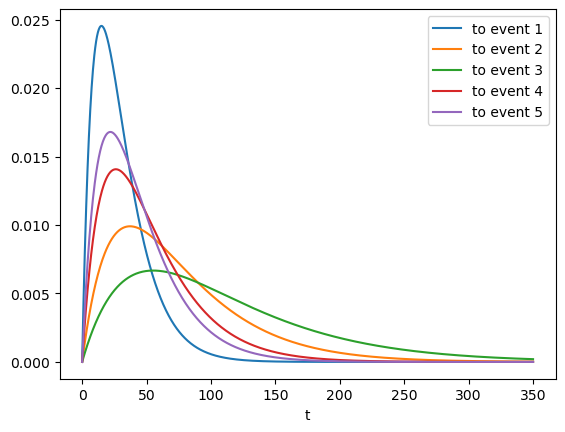

In [13]:
colors = sns.color_palette(None, n_events+1)

T = 350
for event in range(5):
    plt.plot(np.linspace(0,T,1001),gamma.pdf(np.linspace(0,T,1001), 2, scale=true_pars[event,1]), label=f'to event {event+1}', color=colors[event]) 
plt.xlabel('t')
plt.legend()
plt.show()

The width of these distribution indicates the variability of the between-event durations over trials and (with real data) participants.

The second element is the contribution of the different electrodes/magnometers/PCs to each of the event, the `true_mags`. Here we get the estimated magnitudes:

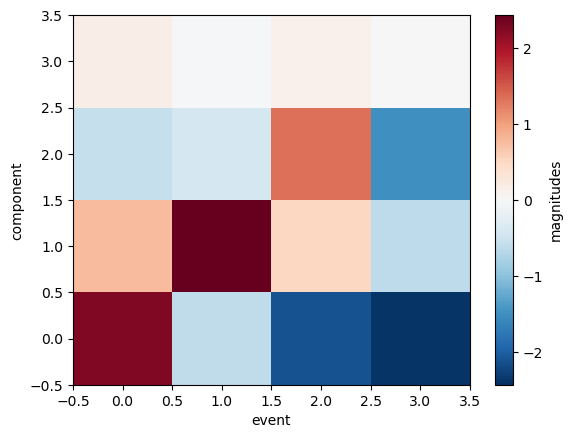

In [14]:
estimates.magnitudes.dropna('event').T.plot()
plt.show()

We used 4 PC components (y-axis) to estimate 4 events. As is visible in the matrix above, each event has a unique combination of component contributions, although this is not a requirement.

To estimate this set of parameters (magnitudes and time distributions) we use the expectation maximization algorithm on the event probability as obtained through the Baum-Welsh algorithm. 

Now we do not provide the true magnitudes and parameters as starting points, but start with neutral ones (0's for the magnitudes, mean duration / n_events for the average between event duration).

Estimating 4 events model with 1 starting point(s)
parameters estimated for 4 events model


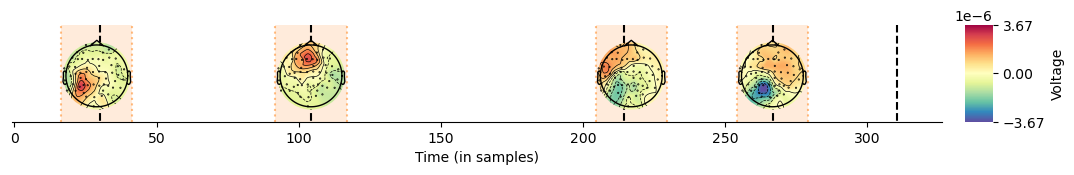

In [15]:
estimates = init.fit_single(n_events)

hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, magnify=1, sensors=True, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

Also without providing the true magnitudes and parameters, the algorithm manages to recover the events in the simulated data.

We can inspect the traces of the EM algorithm to see how the log-likelihood of the fit developed with iterations. This shows how many iterations it needed and at what Log-likelihood (LL) it stopped according to the default tolerance on the increase in LL (default 1e-4).

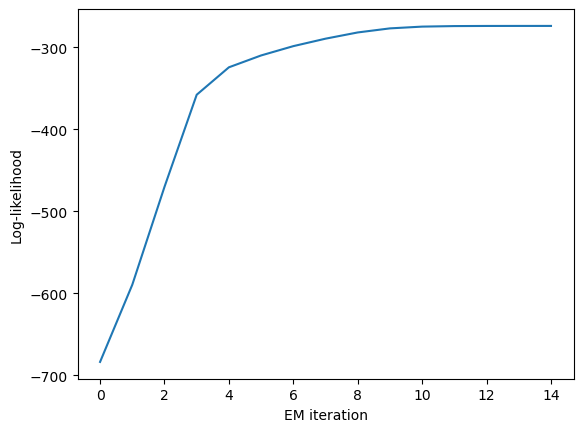

In [16]:
plt.plot(estimates.traces)
plt.ylabel('Log-likelihood')
plt.xlabel('EM iteration')
plt.show()

For simulated data, we can also check how well our model recovered the original values for the electrode contributions and time distributions.

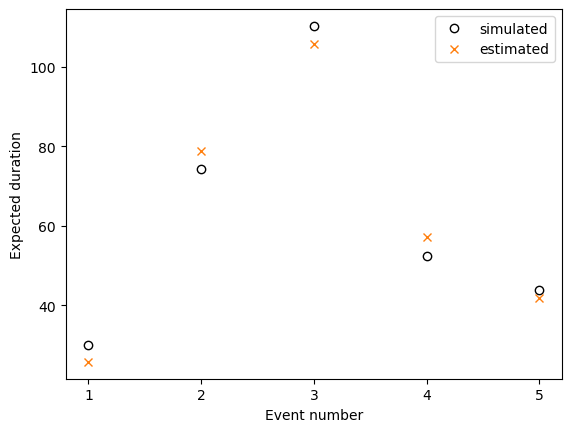

In [17]:
plt.plot(true_pars.prod(axis=1), 'o', label='simulated',mec='k', mfc='w', )
plt.plot(estimates.parameters.prod(axis=1), 'x', label='estimated')#prod() is for a gamma only
plt.xticks(range(5),[1,2,3,4,5])
plt.legend()
plt.xlabel('Event number')
plt.ylabel('Expected duration')
plt.show()

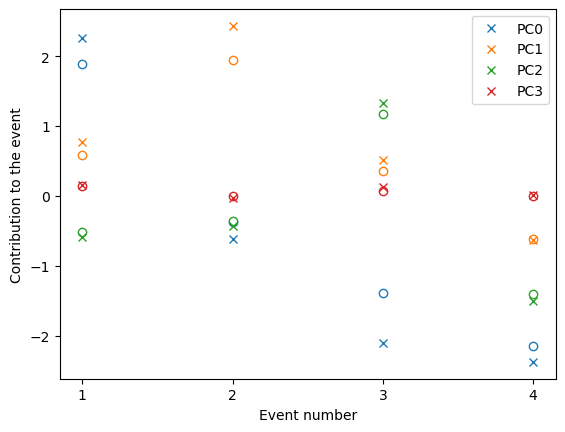

In [18]:
for pc in range(init.n_dims):
    plt.plot(estimates.magnitudes.sel(component=pc), 'o', mec=colors[pc], mfc='w')
    plt.plot(true_magnitudes[:,pc], 'x', label=f'PC{pc}', color=colors[pc])
plt.xticks(range(4),[1,2,3,4])
plt.xlabel('Event number')
plt.ylabel('Contribution to the event')
plt.legend()
plt.show()

## Exploiting model estimates

In the end, what we are really interested in is the event probabilities, the probability of event occurring at each sample in every trial of every participants, as this allows us to do interesting follow-up analyses.

Let's check what these look like:

In [19]:
estimates.eventprobs

<xarray.DataArray 'eventprobs' (trial_x_participant: 100, samples: 719, event: 4)> Size: 2MB
array([[[0.00000000e+00, 8.80881208e-20, 2.61961396e-20, 2.76442112e-21],
        [2.75227504e-03, 1.66562852e-19, 3.77536892e-20, 0.00000000e+00],
        [5.12500958e-03, 1.07448913e-06, 0.00000000e+00, 4.85664240e-21],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 2.56465633e-20, 3.80725919e-21, 2.87029806e-24],
        [2.77875558e-04, 9.18430000e-21, 2.87751656e-21, 4.58425855e-25],
        [6.99951061e-04, 1.16427107e-08, 3.46408235e-22, 3.43759965e-25],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 1.93944936e-20, 1.89563551e-22, 1.87397705e-26],
        [1.87373591e-05, 6.75668691e-20, 1.70566265e-22, 0.00000000e+00],
        [4.45922569e-05, 6.68117632e-10, 1.17263362e-22, 0.00000000e+00],
        ...,
...
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 2.99523407e-20, 1.15283652e-20, 0.00000000e+00],
        [2.66128993e-04, 2.84413802e-20, 1.56978264e-20, 1.07502128e-23],
        [5.62809696e-04, 1.54653225e-08, 4.30697003e-21, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 1.64047447e-21, 9.43946440e-24, 0.00000000e+00],
        [4.64749517e-04, 1.33498787e-21, 0.00000000e+00, 0.00000000e+00],
        [8.99292929e-04, 3.59921703e-09, 7.83295285e-24, 1.58316708e-28],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * event                (event) int64 32B 0 1 2 3
  * samples              (samples) int64 6kB 0 1 2 3 4 5 ... 714 715 716 717 718
  * trial_x_participant  (trial_x_participant) object 800B MultiIndex
  * participant          (trial_x_participant) object 800B 'S0' 'S0' ... 'S0'
  * trials               (trial_x_participant) int64 800B 0 1 2 3 ... 97 98 99

This is a matrix with dimensions trial x sample_in_trial x event, where the values indicate the probablity of that event occurring at that sample.

We can represent this graphically, for example by plotting the average probability for each event at each time sample:

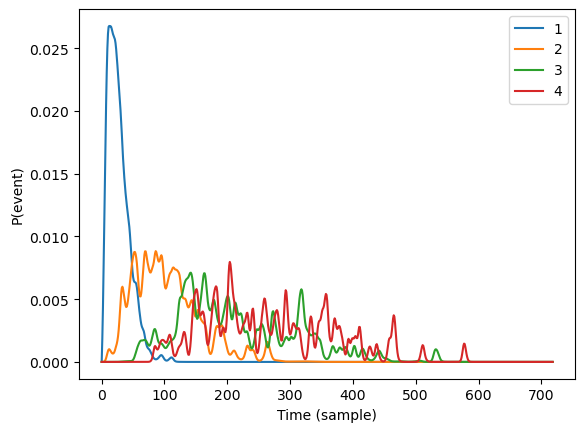

In [20]:
plt.plot(estimates.eventprobs.mean('trial_x_participant'), label=[1,2,3,4])
plt.ylabel('P(event)')
plt.xlabel('Time (sample)')
plt.legend()
plt.show()

And we can even look at a single trial:

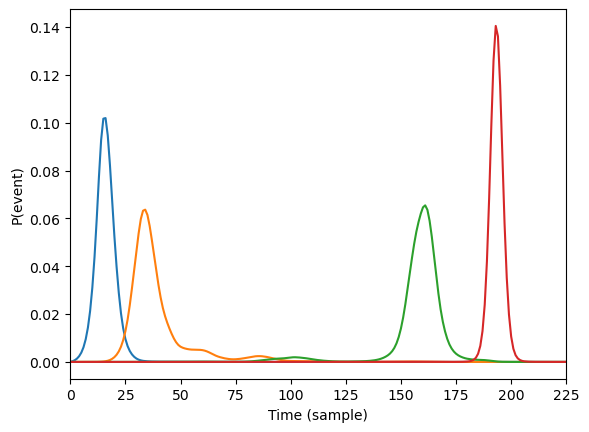

In [21]:
plt.plot(estimates.eventprobs.sel(trial_x_participant=('S0',1)), label=[1,2,3,4])
plt.ylabel('P(event)')
plt.xlabel('Time (sample)')
plt.xlim(0,225)
plt.show()

And in the case of simulation compare that to the actual generating moment for the corresponding trials:

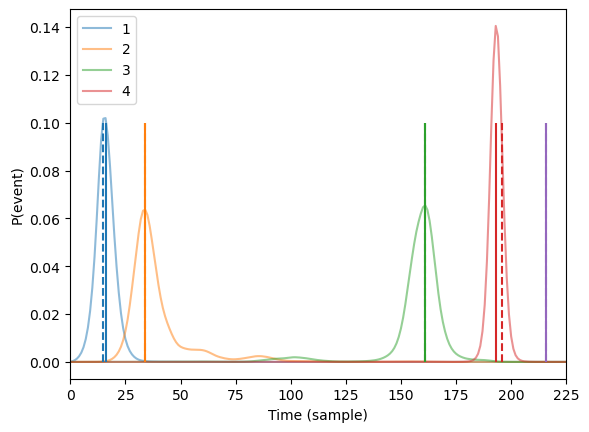

In [22]:
estimated_times = init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T
plt.plot(estimates.eventprobs.sel(trial_x_participant=('S0',1)), label=[1,2,3,4], alpha=.5)
plt.ylabel('P(event)')
plt.xlabel('Time (sample)')
plt.vlines(np.cumsum(sim_source_times[1,:]), 0,.1, color=colors, ls='--')
plt.vlines(np.cumsum(estimated_times.sel(trial_x_participant=('S0',1))), 0,.1, color=colors, ls='-')
plt.legend()
plt.xlim(0,225)
plt.show()

Here the solid lines are the estimated times, while the dotted lines in indicate the simulated events. For this trial, the estimation procedure had trouble locating the fourth events because it does share some information in terms of magnitudes with the third one.

If we select for all trials the most likely sample to contain a transition we can take a look at the recovery of our simulated times on all trials:

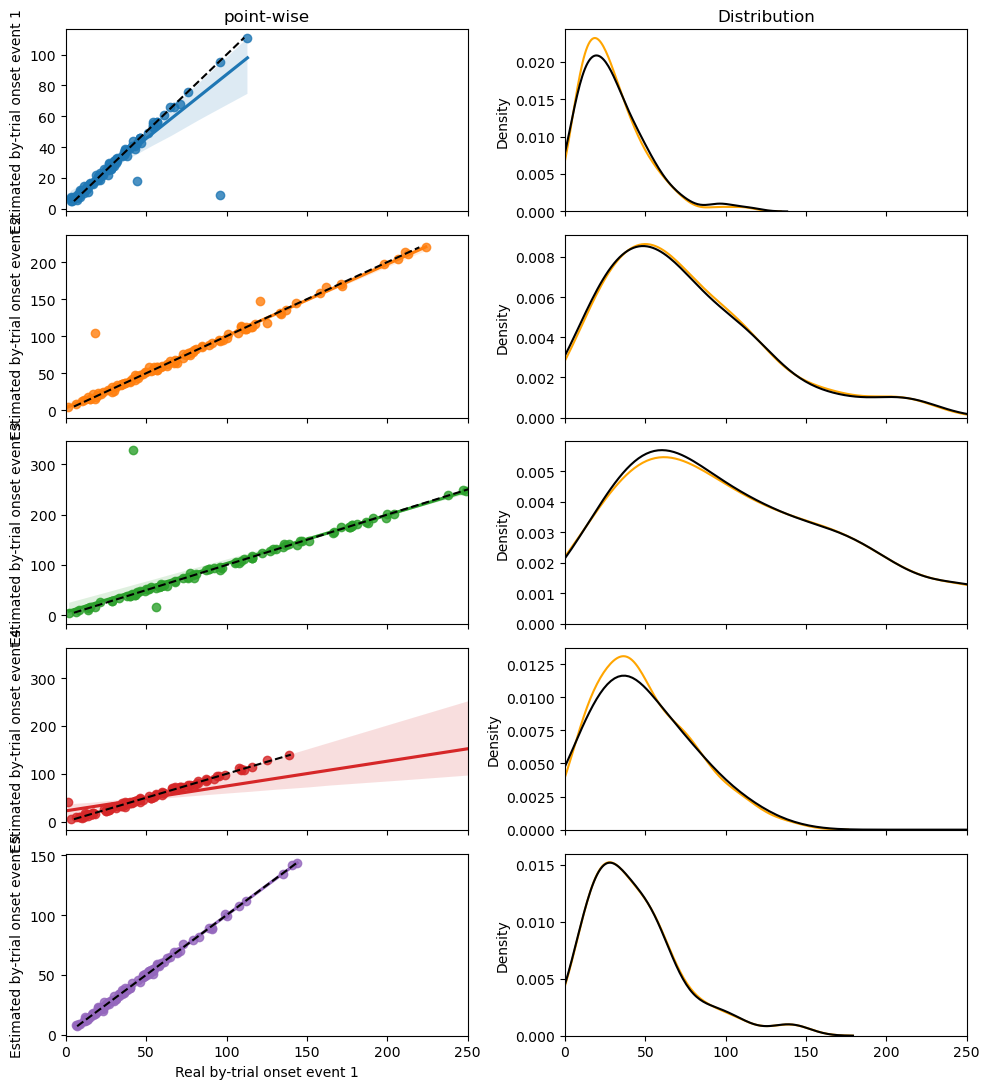

In [23]:
fig, ax = plt.subplots(n_events+1,2, figsize=(10,2.5*n_events+1), dpi=100, sharex=True)
i = 0
ax[0,0].set_title('point-wise')
ax[0,1].set_title('Distribution')
ax[-1,0].set_xlabel(f'Real by-trial onset event {i+1}')

for event in estimated_times:
    sns.regplot(x=sim_source_times[:,i].T, y=event, ax=ax[i,0], color=colors[i])
    ax[i,0].plot([np.min(event), np.max(event)], [np.min(event), np.max(event)],'--', color='k')
    ax[i,0].set_ylabel(f'Estimated by-trial onset event {i+1}')
    sns.kdeplot(event, ax=ax[i,1], color='orange')
    sns.kdeplot(sim_source_times[:,i].T, ax=ax[i,1], color='k')
    i+= 1

plt.xlim(0,250)
plt.tight_layout()
plt.show()

As you can see some trials get miss-estimated from the 3rd to the 4th event (red). Consequently those trials are also mis-estimating in the times between the 4th and the response time. This is related to the confusion between the 3rd and fourt event outlined previously. 

But overall the exact time of the simulated event is detected as the most likely time by HMP!

# Tutorial 2

## Estimating a model with a known number of events

This section will show you how to estimate a single HMP model with a given number of events, as in the previous tutorial, but now we'll make it more realistic and harder to discover.

First we do more or less the same as in the previous tutorial:
- simulate EEG data
- transform the data
- initialize a model with default parameters for distribution, shape and event duration

We now simulate the data by calling the `demo` function, which is only used for this tutorial.

In [ ]:
n_events = 8 #how many events to simulate
epoch_data, sim_source_times, info = demo(cpus, n_events)

We specify directly that we want 4 PC components:

In [ ]:
hmp_dat = hmp.utils.transform_data(epoch_data, n_comp=4)
print(hmp_dat)

And we initialize the model:

In [3]:
init = hmp.models.hmp(hmp_dat, epoch_data, sfreq=epoch_data.sfreq, event_width=50, cpus=cpus)#Initialization of the model

Once the class has been initiated, the function ```fit_single()``` can be used to estimate one hmp model with a specified number of transition events

## Direct estimation
As in the previous tutorial, we can simply call the ```fit_single``` method from the hmp class to estimate a given number of events. The hmp algorithm will then look for ```n_event``` events. 

Unfortunately, the expectation maximization algorithm to fit the model is sensitive to the starting points given to the relative event onsets. By default, the ```fit_single``` method uses a starting point where all events are equally distributed between 0 and the mean RT, and the magnitudes are set to 0.

Estimating 8 events model with 1 starting point(s)
parameters estimated for 8 events model


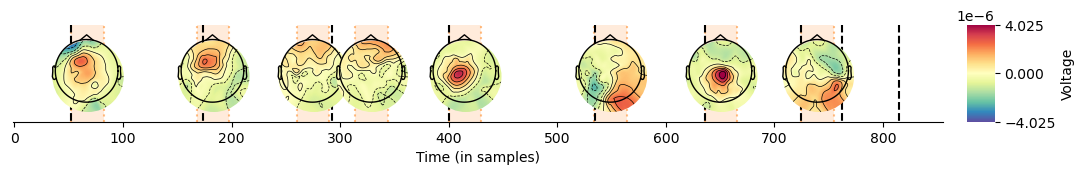

In [4]:
#Fitting
selected = init.fit_single(n_events)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As you can see, the method discovers 8 events - as we told it to - but one of them is at the wrong location (the vertical lines indicate the true event locations).

Thus, launching a single model without additional starting points is not a good idea as sometimes the default starting values of the expectation maximization algorithm will end up in a local minima, as above.

To see what happens if we just use the default inputs and set maximization to False:

Estimating 8 events model with 1 starting point(s)
parameters estimated for 8 events model


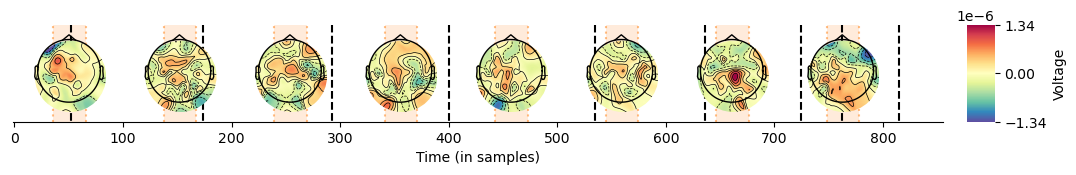

In [5]:
#Fitting
selected = init.fit_single(n_events, maximization=False)#function to fit an instance of a 10 events model

#Visualizing
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, magnify=1, sensors=False, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As expected, the 'discovered' events are divided equally over the mean RT. The magnitudes are not 0, as we're plotting the average EEG data at the discovered time points in each trial - as you can see these averages are quite random, and also have very small amplitudes compared to the graph above.

The lesson we learned: we need to use more starting points!

## Random method

In reality, we do not know where the real events are. Thus, a better idea is to run a single model with several starting points and selecting the result with the best fit. This can be declared in the ```single_fit()``` function; here we estimate an example with 50 random starting points. We set `return_max` to False to get all models back, instead of only the winning one. 

We then sort the models by log-likelihood - how well they explain the EEG data - and plot every 5th model.

Estimating 8 events model with 50 starting point(s)


  0%|          | 0/50 [00:00<?, ?it/s]

parameters estimated for 8 events model


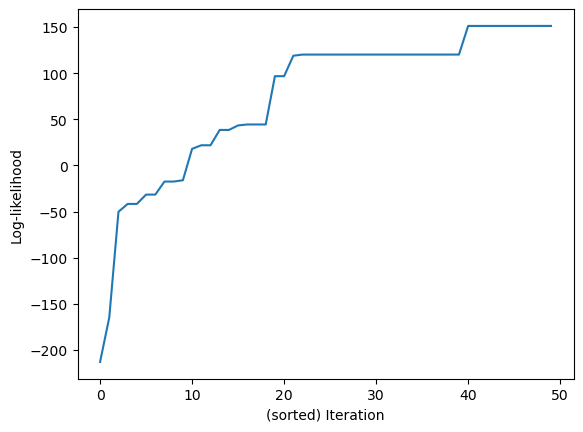

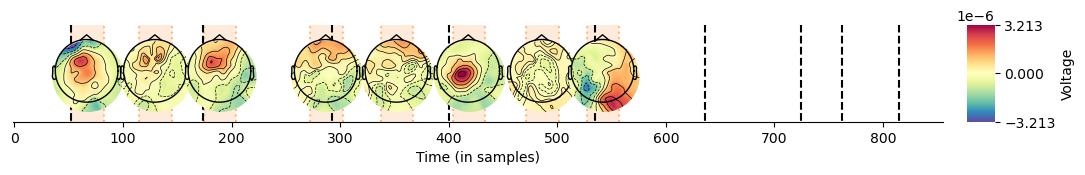

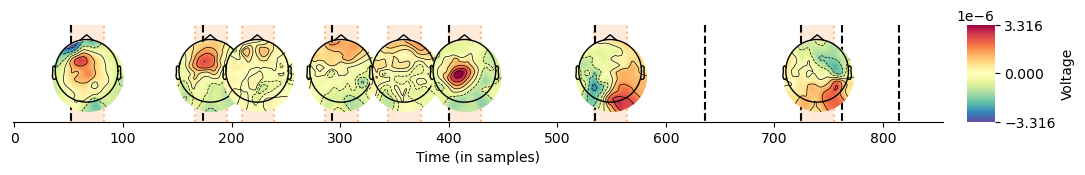

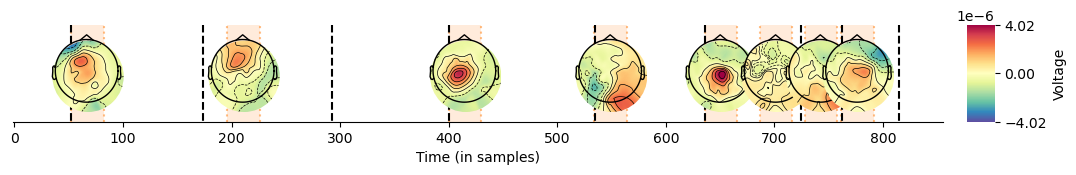

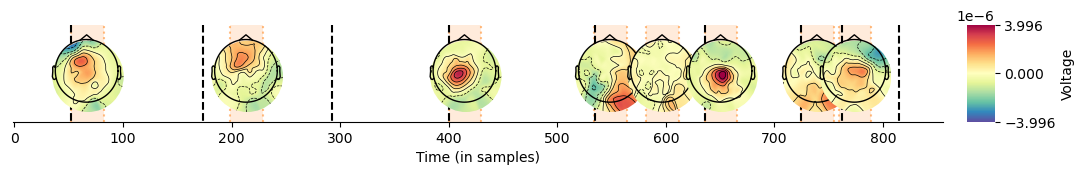

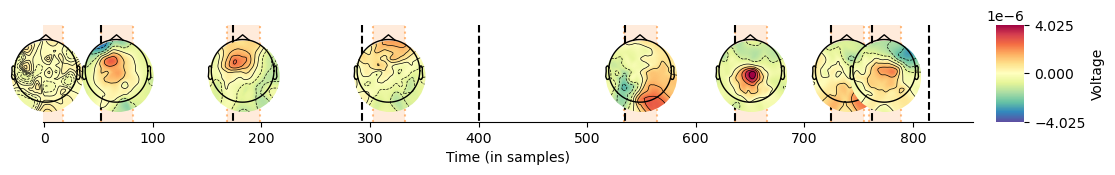

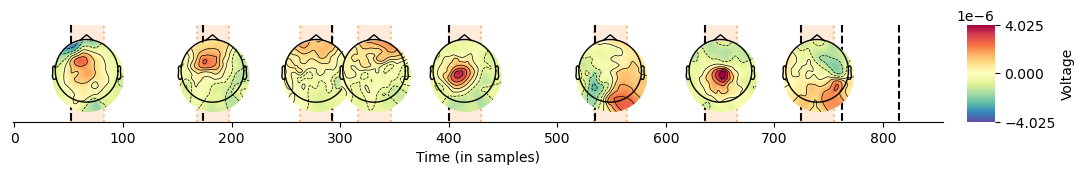

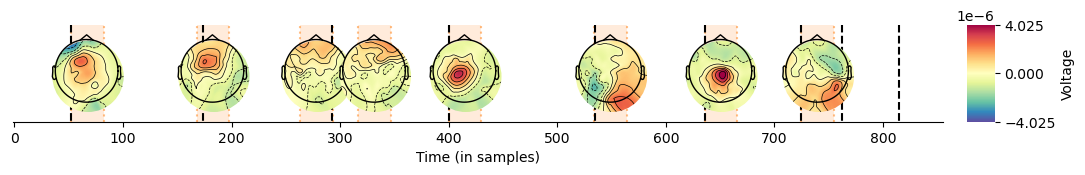

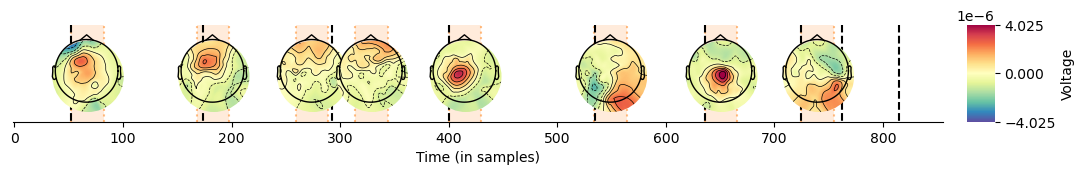

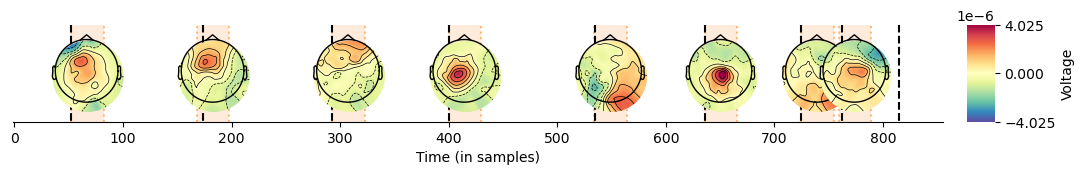

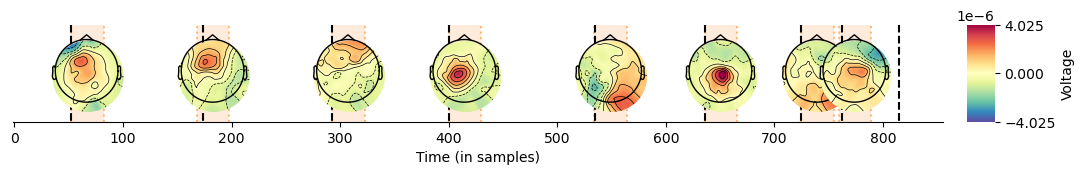

In [8]:
#NOTE: if you run this in VS code on a Mac in an interactive window, you might get strange behavior (running of previous processes) due to the multiprocessing. If so, set your multiprocessing start method to 'fork' (which is the default on Unix) by uncommenting the next two lines:
#import multiprocessing as mp
#mp.set_start_method("fork")

# Fitting
selected = init.fit_single(n_events, method='random', starting_points=50,
                           return_max=False)#function to fit an instance of a 4 events model

plt.plot(selected.sortby('likelihoods').likelihoods)#Sorted starting point iteration based on log-likelihood
plt.xlabel('(sorted) Iteration')
plt.ylabel('Log-likelihood')
for iteration in selected.sortby('likelihoods').iteration[::5]:#Only plot every 5 model
    hmp.visu.plot_topo_timecourse(epoch_data, selected.sel(iteration=iteration), info, init, magnify=1, sensors=False, times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

As you can see, the higher the likelihood, the closer the discovered events are to the real events. As a side note, instead of recording all those starting points we can just take the most likely one directly by setting `return_max` to True.

But, by definition, the starting points are random: as a result they induce a lot of redundancy and you take the risk that some points in the parameter space remain unexplored. Several calls to this function will not always give the correct solution if not enough starting points have been provided. Below we will explore better/additional solutions to this issue.

## Backward estimation

Another solution than using random points is to first estimate a model with the maximal number of possible events that fit in RTs (referred to as 'the maximal model'), and then decrease the number of events one by one.

The idea is that genuine events will necessarily be found at the expected locations in the maximal model. Because the backward estimation method iteratively removes the weakest event (in terms of likelihood), only the 'strongest' events remain even if their location would have been hard to find with a single fit and default starting values.

In order to do this we will use the ```backward_estimation()``` function. This function first estimates the maximal model (defined based on the event width and the minimum reaction time), then estimates the max_event - 1 solution by iteratively removing one of the events and picking the next solution with the highest likelihood (for more details see Borst & Anderson, [2021](http://jelmerborst.nl/pubs/ACTR_hmp_MVPA_BorstAnderson_preprint.pdf)) and repeat this until the 1 event solution is reached. 

In [10]:
%%time 
bests = init.backward_estimation(max_events=int(init.compute_max_events()))#here we take the floor division by 2 to go faster

Estimating all solutions for maximal number of events (22) with 1 pre-defined starting point and 0 random starting points
Previous model did not fit well. Estimating a neutral 21 event model.
Estimating 21 events model with 1 starting point(s)
parameters estimated for 21 events model
Estimating all solutions for 20 events
Estimating all solutions for 19 events
Estimating all solutions for 18 events
Estimating all solutions for 17 events
Estimating all solutions for 16 events
Estimating all solutions for 15 events
Estimating all solutions for 14 events
Estimating all solutions for 13 events
Estimating all solutions for 12 events
Estimating all solutions for 11 events
Estimating all solutions for 10 events
Estimating all solutions for 9 events
Estimating all solutions for 8 events
Estimating all solutions for 7 events
Estimating all solutions for 6 events
Estimating all solutions for 5 events
Estimating all solutions for 4 events
Estimating all solutions for 3 events
Estimating all solut

Here we plot the resulting solutions going from the maximal possible number of events (16) all the way to a single event. 

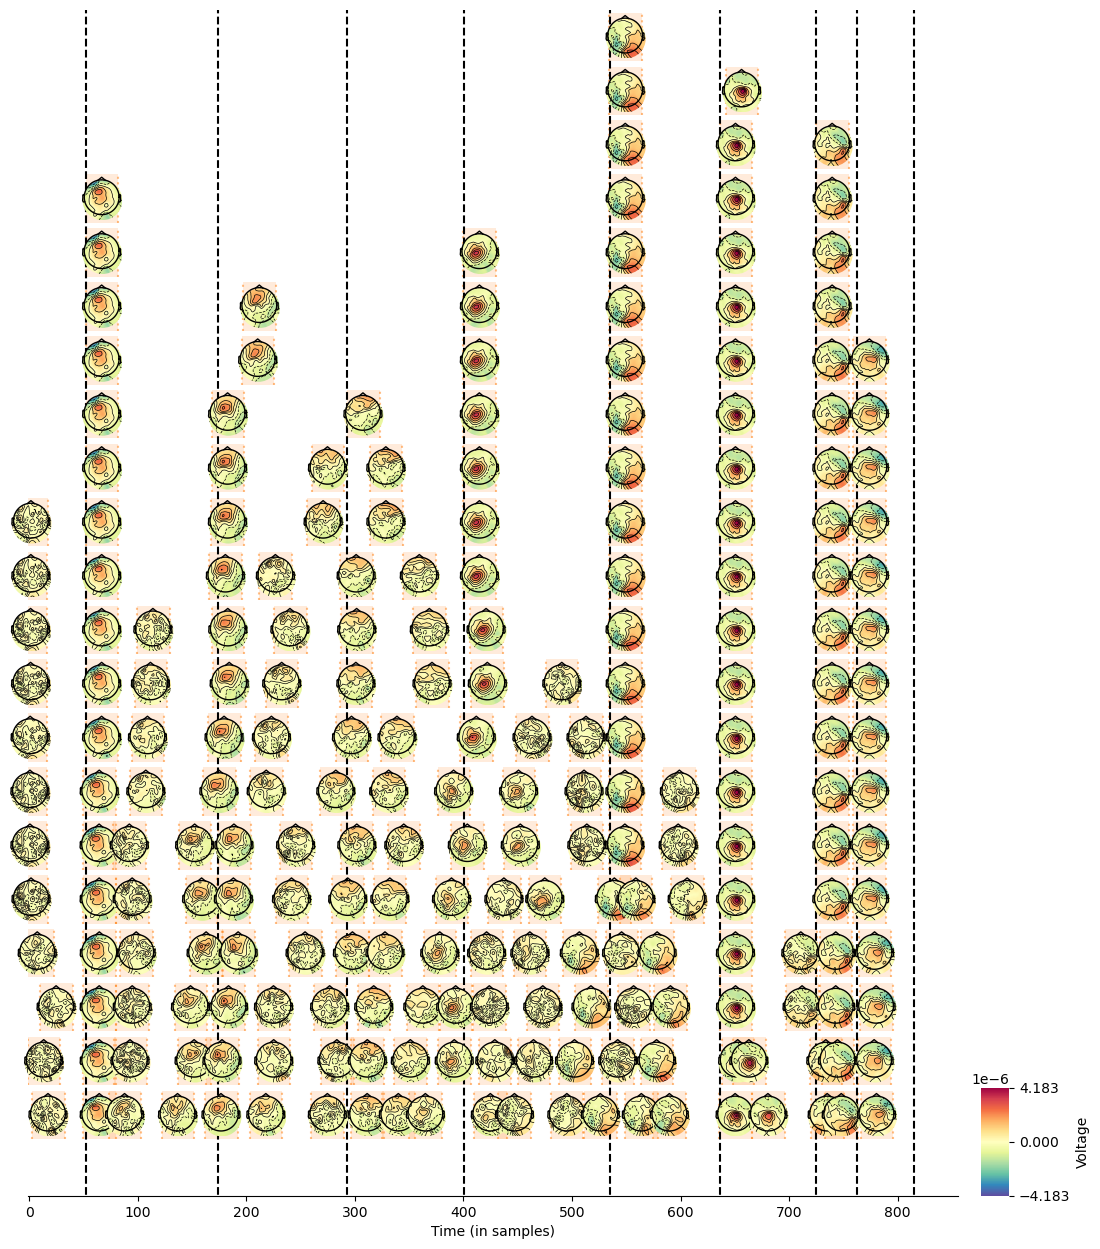

In [11]:
hmp.visu.plot_topo_timecourse(epoch_data, bests, info, init, sensors=False,
                    times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

As you can see, the 15-event solution finds the real events + some extra ones (which typically look very weak). From these solutions we can select the number of events we originally wanted to estimate (which is the correct solution in this case):

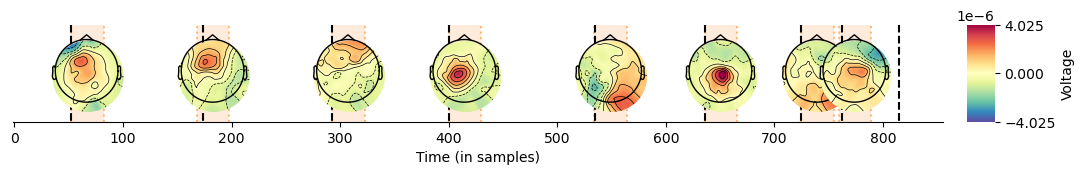

In [12]:
selected = bests.sel(n_events=n_events)
hmp.visu.plot_topo_timecourse(epoch_data, selected, info, init, sensors=False,
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

The downside is that we are still unsure about whether we included all possible starting points in the mix. In addition, this method can be suboptimal with 1) long RTs and therefore a lot of events to fit and long computation times and 2) if there is a big difference between the minimum RT (determining the maximum number of events) and the mean RT (all possible locations of these events).

## Cumulative event fit

Instead of fitting an _n_ event model this method starts by fitting a 1 event model using each sample from the time 0 (stimulus onset) to the mean RT. Therefore it tests for the landing point of the expectation maximization algorithm given each sample as starting point and the likelihood associated with this landing point. As soon as a starting points reaches the convergence criterion, the function fits an _n+1_ event model and uses the next samples in the RT for the following event, etc.

  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Event found at sample 67
Events at [ 67 814]
lkh change: <xarray.DataArray 'likelihoods' ()> Size: 8B
array(71.29377674)
Transition event 1 found around sample 67

Event found at sample 218
Events at [ 67 218 814]
lkh change: 22.081269574972026
Transition event 2 found around sample 218

Event found at sample 548
Events at [ 66 229 548 814]
lkh change: 112.69000323744237
Transition event 3 found around sample 548

Event found at sample 662
Events at [ 66 229 550 662 814]
lkh change: 126.96442910356879
Transition event 4 found around sample 662

Event found at sample 744
Events at [ 66 229 549 651 744 814]
lkh change: 101.68696055731644
Transition event 5 found around sample 744

Event found at sample 782
Events at [ 66 229 549 650 739 782 814]
lkh change: 12.284350033951682
Transition event 6 found around sample 782

Event found at sample 811
Events at [ 66 226 542 641 717 764 811 814]
lkh change: -119.77085406009753

All events found, refitting final combination.


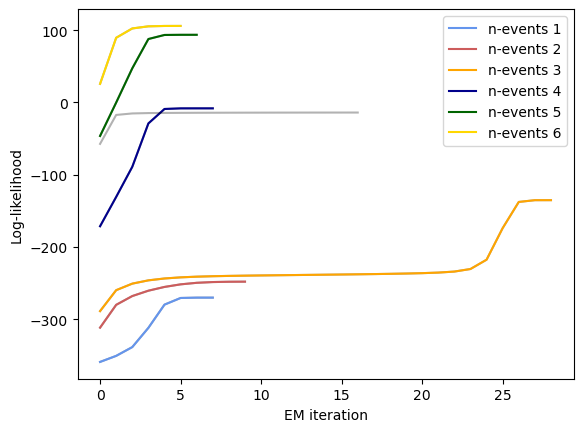

Estimating 6 events model
parameters estimated for 6 events model


In [13]:
estimates = init.fit(diagnostic=True)

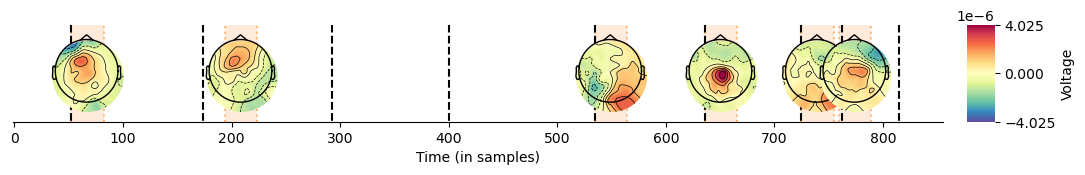

In [14]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, 
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

Almost perfect but we're missing one! This comes as the EM algorithm might skip a convergence point as it jumps from one local minima to the other because the next one had a higher likelihood (see the orange EM curve). To overcome this we can use the ```by_sample``` method that re-test samples between local convergence point to check for additional missed events. See for example:

  0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


Event found at sample 67
Events at [ 67 814]
lkh change: <xarray.DataArray 'likelihoods' ()> Size: 8B
array(64.81622433)
Transition event 1 found around sample 67

Event found at sample 72
Events at [  5  72 814]
lkh change: -20.687393929969176

Event found at sample 218
Events at [ 67 218 814]
lkh change: 22.0736082572042
Transition event 2 found around sample 218

Event found at sample 548
Events at [ 66 229 548 814]
lkh change: 112.69827510861643
Transition event 3 found around sample 548

Event found at sample 548
Events at [ 66 192 330 548 814]
lkh change: 10.458709392739834
Transition event 4 found around sample 548

Event found at sample 547
Events at [ 66 185 304 419 547 814]
lkh change: 35.14237001625163
Transition event 5 found around sample 547

Event found at sample 548
Events at [ 65 172 254 333 426 548 814]
lkh change: -18.682899966669638

Event found at sample 548
Events at [ 65 172 254 333 426 548 814]
lkh change: -18.697636158238154

Event found at sample 548
Events a

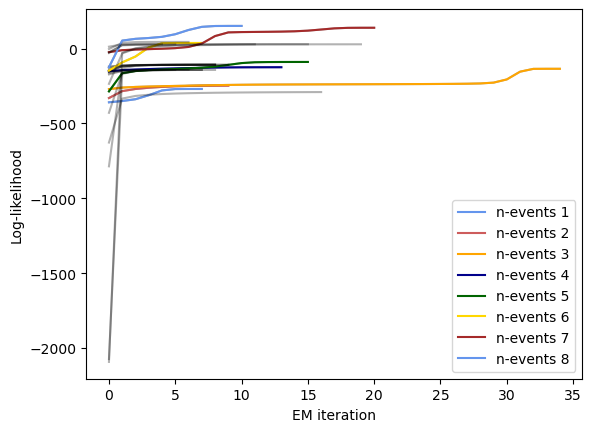

Estimating 8 events model
parameters estimated for 8 events model


In [15]:
estimates = init.fit(diagnostic=True, by_sample=True)

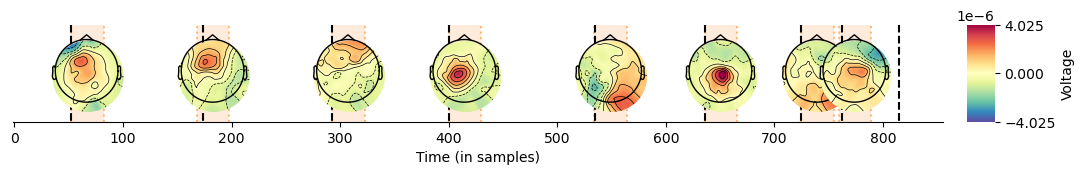

In [16]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, 
                                times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0), magnify=1)

Now it's perfect!

# Data saving

Once finished we can save fitted models using the dedicated command

In [17]:
hmp.utils.save_fit(selected, 'selected.nc')

selected.nc saved


<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


And load the same way

In [18]:
estimates = hmp.utils.load_fit('selected.nc')

Or even only save the estimated event probabilities 

In [19]:
hmp.utils.save_eventprobs(selected.eventprobs, 'selected_eventprobs.nc')

Saved at selected_eventprobs.nc


# Tutorial 3

# Discovering the number of events

We usually do not have precise enough information to decide a priori on a number of events that an HMP model should have. To illustrate the problem let's use the data from application 2 of this [this](https://link.springer.com/article/10.1007/s42113-021-00105-2) paper. For the purpose of this tutorial we will only use the last four participants of the data (see [this](https://www.sciencedirect.com/science/article/pii/S1053811914002249) paper for the method and [https://osf.io/pd3kf/](https://osf.io/pd3kf/) for the whole (unpreprocessed) data).

In this experiment, participants performed a random-dot motion task. They were asked to indicate the direction of motion of a cloud of moving dots. While a proportion of the dots moved in a target direction, the remainder moved randomly and makes the direction discrimination more difficult. Difficulty of the task was calibrated per subject. Prior to each trial, participants received a cue that indicated whether they should respond as quickly as possible or whether they should focus on giving an accurate response: the 'speed' and 'accuracy' conditions. In this tutorial we will ignore the difference between these conditions, but in the next tutorial we will look at how we can take conditions into account in the HMP analysis.

In this tutorial we will look at three different ways to discover and test the number of events in the data:
- clustering
- leave-one-out-cross validation (LOOCV)
- bootstrapping

## Data preparation

First, we load the required packages and load the data.

In [1]:
import os
import numpy as np



# EEG data
epoch_data = xr.load_dataset(os.path.join('../sample_data/sample_data.nc'))

# channel information
info = read_info(os.path.join('../sample_data/eeg/processed_0022_epo.fif'), verbose=False)

print(epoch_data)
info

<xarray.Dataset>
Dimensions:      (epochs: 200, channels: 30, samples: 197, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 190 191 192 193 194 195 196
    stim         (participant, epochs) float64 2.0 1.0 1.0 1.0 ... nan 2.0 1.0
    resp         (participant, epochs) object 'resp_left' ... 'resp_left'
    rt           (participant, epochs) float64 0.942 1.003 1.129 ... 0.392 0.376
    cue          (participant, epochs) object 'SP' 'AC' 'AC' ... '' 'SP' 'SP'
    movement     (participant, epochs) object 'stim_right' ... 'stim_left'
    trigger      (participant, epochs) object 'SP/stim_right/resp_left' ... '...
  * participant  (participant) object 'processed_0025_epo' ... 'processed_002...
Data variables:
    data         (participant, epochs, channels, samples) float64 2.891 ... nan
Attribute

<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, AFz, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, ...
 chs: 30 EEG
 custom_ref_applied: True
 dig: 33 items (3 Cardinal, 30 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 35.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 30
 projs: []
 sfreq: 100.0 Hz
>

At this point we have the epoched EEG data with 30 channels, which we need to transform to PC space. When transforming the data, a prompt requests how many PCs we want to keep. The best is to maximise the number of components kept so that we don't loose PCs with useful information. However, the more PCs we include the more computationally intensive the estimations will be. For this two rules of thumb exists, taking PCs that explain x% of the variance of the data or select the PC number at which the explained variance seems to almost stop decreasing (i.e. the "elbow" method).

The HMP `transform_data` function will show you the two graphs below, and asks you how many PCs you would like to retain:

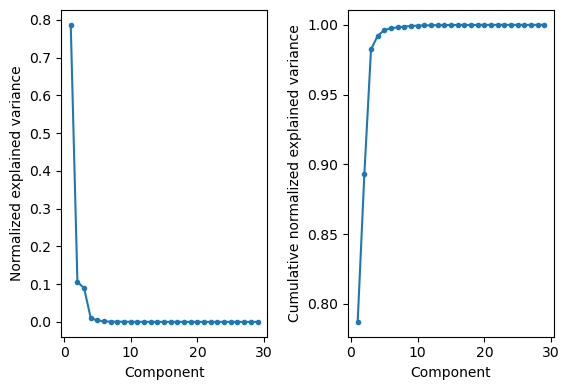

How many PCs (90 and 99% explained variance at component n3 and n4)? 4


In [2]:
hmp_data = hmp.utils.transform_data(epoch_data)

In this case we see that 99% explained variance is achieved with 4 PCs, and that this is coherent with when the explained variance really drops (with a larger number of electrodes than the 30 used here, 99% might be achieved with more PCs, but the elbow might occur before).

In [3]:
print(hmp_data)

<xarray.DataArray (component: 4, all_samples: 52641)>
array([[-0.10106488,  0.45274679,  0.49624525, ...,  2.665008  ,
         1.89849643,  0.61464273],
       [ 0.12704411,  0.31311483,  0.31347408, ...,  1.81450104,
         0.79202774,  0.67887613],
       [ 0.2633602 ,  0.20079646,  0.22488654, ...,  0.48557384,
        -0.08047907, -0.83424832],
       [ 0.0746366 , -0.55167999, -0.4654076 , ...,  1.54833361,
         0.9687482 ,  0.41217429]])
Coordinates:
  * component    (component) int64 0 1 2 3
    stim         (component, all_samples) float64 2.0 2.0 2.0 ... 1.0 1.0 1.0
    resp         (component, all_samples) object 'resp_left' ... 'resp_left'
    rt           (component, all_samples) float64 0.942 0.942 ... 0.376 0.376
    cue          (component, all_samples) object 'SP' 'SP' 'SP' ... 'SP' 'SP'
    movement     (component, all_samples) object 'stim_right' ... 'stim_left'
    trigger      (component, all_samples) object 'SP/stim_right/resp_left' .....
  * all_samples  (a

The data is now arranged as 4 PCs x 52641 samples: all trials of all participants were concatenated for the remainder of the analysis.

Finally, we need to initialize the model.

In [4]:
init = hmp.models.hmp(hmp_data, epoch_data, event_width=50, cpus=3)

# Clustering

The first method that we will use to determine the number of events that are present in the data is clustering. We introduced this method in the previous tutorial:
- it first explores the space by sliding a single event across the trials, and stores solutions where the HMP estimation converges.
- we repeat this with different starting points on both parameters and magnitudes to get a better appreciation of the space.
- we can then cluster the discovered events to see how many there are.

As the first step, we test 81 models with different parameters and magnitudes (to test only a subset, use `decimate_grid`):

Number of potential magnitudes: 81


  0%|          | 0/81 [00:00<?, ?it/s]

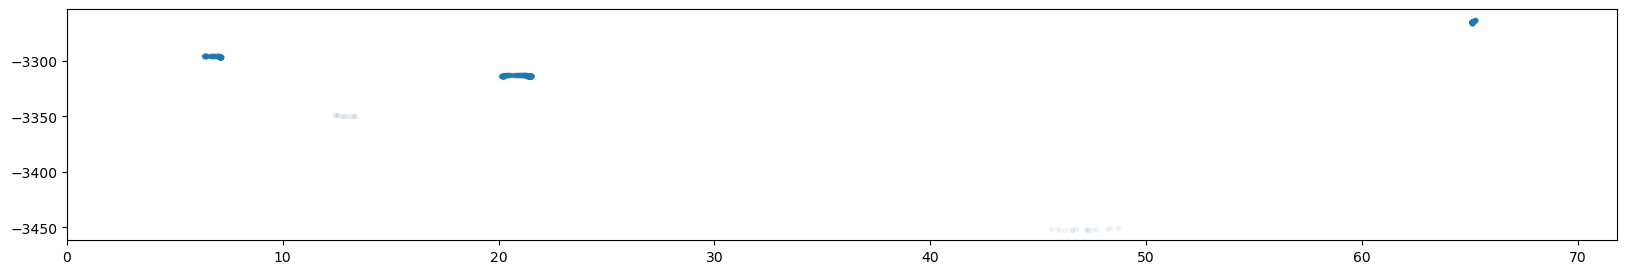

In [5]:
#calc estimates
lkhs, mags, channels, times = init.sliding_event_mags(epoch_data, step=3, decimate_grid= 1, cpu=cpus, plot=True, min_iteration=10)

The plot shows five clusters at different times, where the fourth one is weaker than the others, both in how often it was discovered and in likelihood. We store the likelihoods, times, topologies (channels), and magnitudes of all solutions.

Next, we use kmeans clustering, taking likelihood, time-of-occurence, and magnitudes into account. We also remove outliers based on the mahalanobis distance. The clustering method proposes a number of clusters based on the silhouette coefficients. If you agree with the solution (5) - as we do here - enter 0, if not, enter the number of clusters you would like to explore.

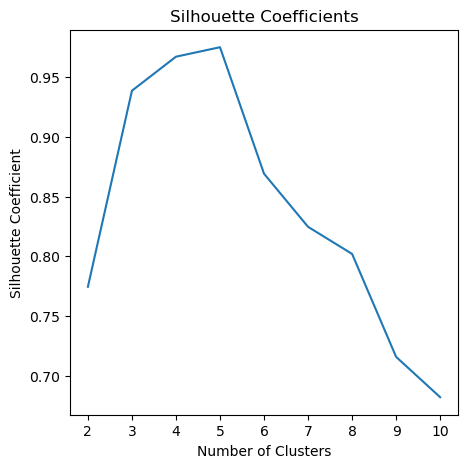

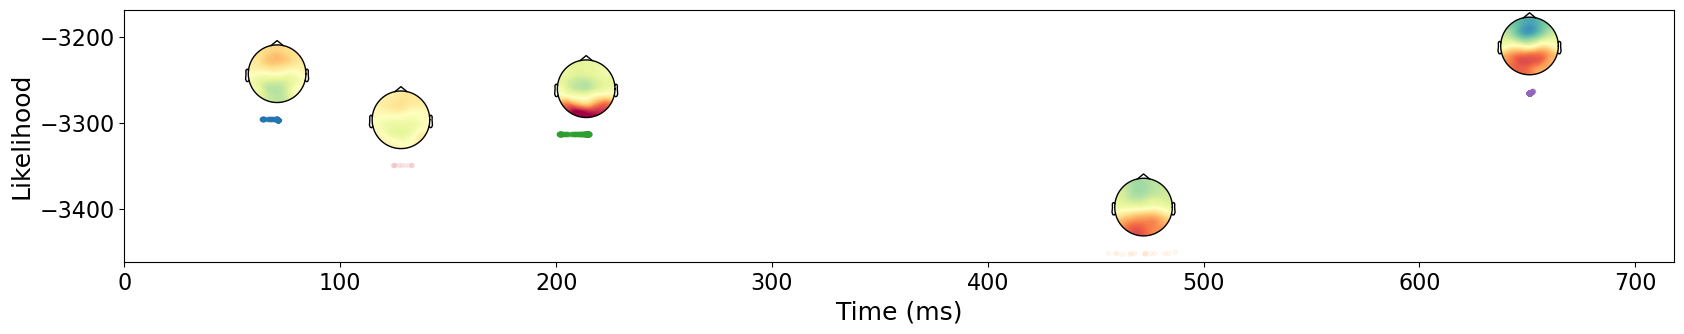

Do you agree with this solution [enter '0'], or would you like to explore a different number of clusters [enter the number of clusters]? 0


In [6]:
# cluster in time, lkh, and mags
mags_cl, pars_cl = hmp.clusters.cluster_events(init, lkhs, mags, channels, times, method='time_x_lkh_x_mags', max_clust=10, p_outlier=.05, info=info, calc_outliers=True)

Finally, we fit the selected model using the magnitudes and parameters of the clustering as input:

Estimating 5 events model
parameters estimated for 5 events model


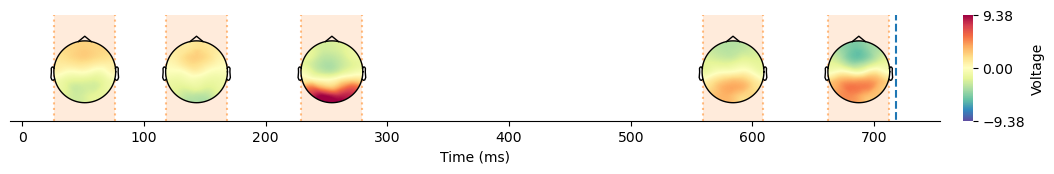

In [7]:
#fit final model
best_estimate = init.fit_single(mags_cl.shape[0], magnitudes=mags_cl,parameters=pars_cl)
hmp.visu.plot_topo_timecourse(epoch_data, best_estimate, info, init, magnify=1, sensors=False, contours=0, event_lines=True, colorbar=True, as_time=True)

As you can see, the solution is a bit different from the results of the clustering method itself, because now it estimates five events simultaneously. To counter this problem, we developed the fit() method, also introduced in the previous tutorial. In the next section we will combine it with leave-one-out-cross validation to discover the number of events we have evidence for.

# Leave-one-out-cross validation (LOOCV)

The cluster method gave us an initial idea of which events occur in our data. Now we want to test statistically to what extent the different events generalize across subjects.

To start, we use the `fit` method to calculate the 'maximum solution' – it will find all likely events in the data. As introduced in Tutorial 2, the ```fit``` function slides potential events from 0 to mean RT. When an event is found – the Expectation Maximization estimation converges – one event is added to the model and the slide continues. This way we can detect new events while accounting for the previous ones. 

  0%|          | 0/72 [00:00<?, ?it/s]

Transition event 1 found around sample 8
Transition event 2 found around sample 25
Transition event 3 found around sample 30
Transition event 4 found around sample 36
Transition event 5 found around sample 40
Transition event 6 found around sample 68
Estimating 6 events model
parameters estimated for 6 events model


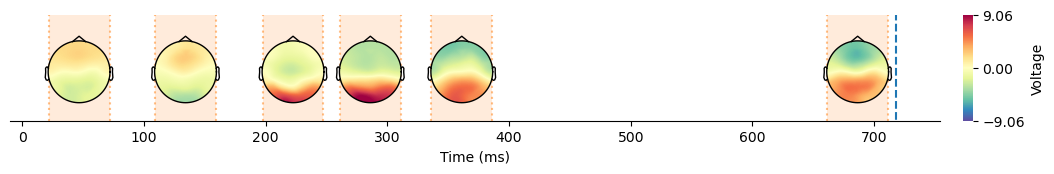

In [9]:
#estimate maximal model using fit
max_model = init.fit()
hmp.visu.plot_topo_timecourse(epoch_data, max_model, info, init, as_time=True,contours=0)

Here the `fit` method found six events – one more than with the clustering method. Next, we use `backward_estimation` – as introduced in the previous tutorial – to generate probable solutions with different numbers of events. We use the 'maximum solution' from the `fit` function as the starting point.

Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events


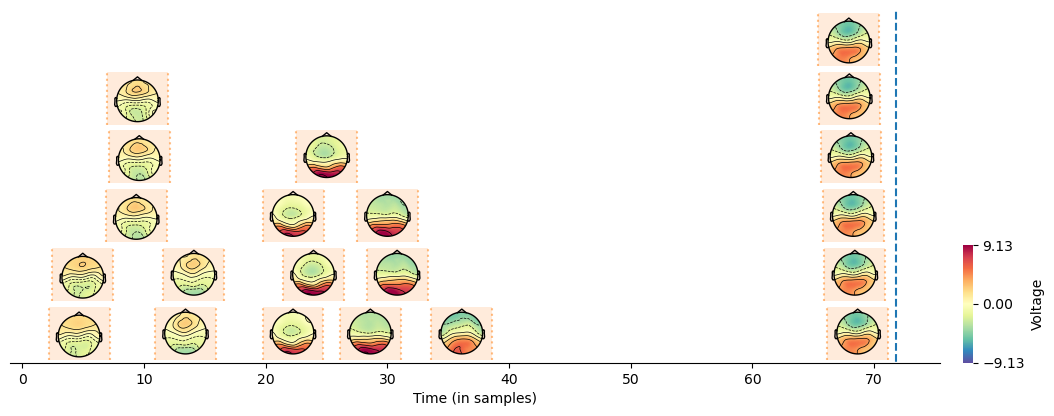

In [10]:
backward_model = init.backward_estimation(max_fit=max_model)
hmp.visu.plot_topo_timecourse(epoch_data, backward_model, info, init)

These results clearly show the 'strongest' events, and just by looking at the graph one might opt for either the three or four event model – with more events we get 'copies'. To determine which of the models really describes the data best, one might be inclined to look at the raw likelihood of the solutions:

Text(0.5, 0, 'N-event model')

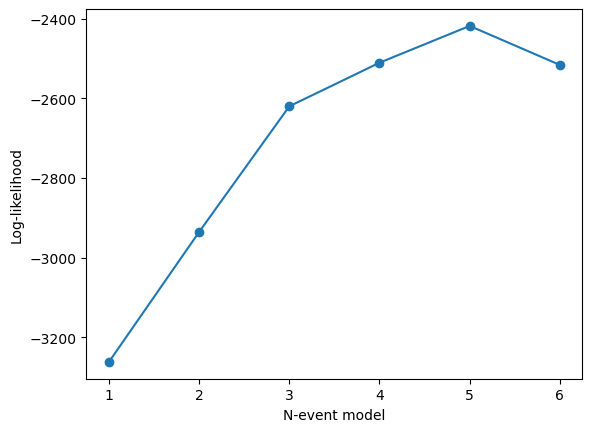

In [11]:
import matplotlib.pyplot as plt 

plt.plot(backward_model.n_events, backward_model.likelihoods,'o-')
plt.ylabel('Log-likelihood')
plt.xlabel('N-event model')

Unfortunately, adding more parameters will almost always improve the fit (except when events start pushing each other away because of the defined minimum duration), here up to five events.

Hence we need a way to penalize the likelihood if solutions do not generalize to all participants. One way to do this is to perform leave-one out cross validation (LOOCV). This approach consists of fitting the model to all participants but one, and evaluate the likelihood of the left out participant given the estimated parameters on the other participants. The function ```hmp.utils.loocv``` does exactly this. If we give it any model as input (including the results of backward estimation), it will fit models with the given model as starting points on _n-1_ participants and estimate the likelihood of the _nth_ participant, and repeat this for all _n_.

Note that LOOCV can be slow when there are many participants, in this case it might be worth it to add multiprocessing through the cpus parameter. However, this increases the memory use, so try to balance CPU use and memory depending on your situation.

In [12]:
loocv_model = hmp.utils.loocv(init, hmp_data, backward_model)


IMPORTANT:  This loocv procedure is incorrect in the sense that an initial estimate
is used to inform both the fit of the left-out participant and the other participants.
This means that they are not fully independent, unless the initial estimate is
based on the literature or another task. However, it does give a very good initial
idea of the correct loocv procedure and is relatively quick.

To do loocv correctly, use loocv_backward or the general loocv_func,
which calculate the initial estimate for every fold by applying
backward estimation or your own function, respectively.

LOOCV started for 1 model(s)
	LOOCV for backward estimation models with [6 5 4 3 2 1] event(s)
	  Estimating backward estimation model with 6 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo
	  Estimating backward estimation model with 5 even

We can then plot the result from the LOOCV procedure, with the likelihood per participant in the graph on the left, and the changes in likelihood on the right.

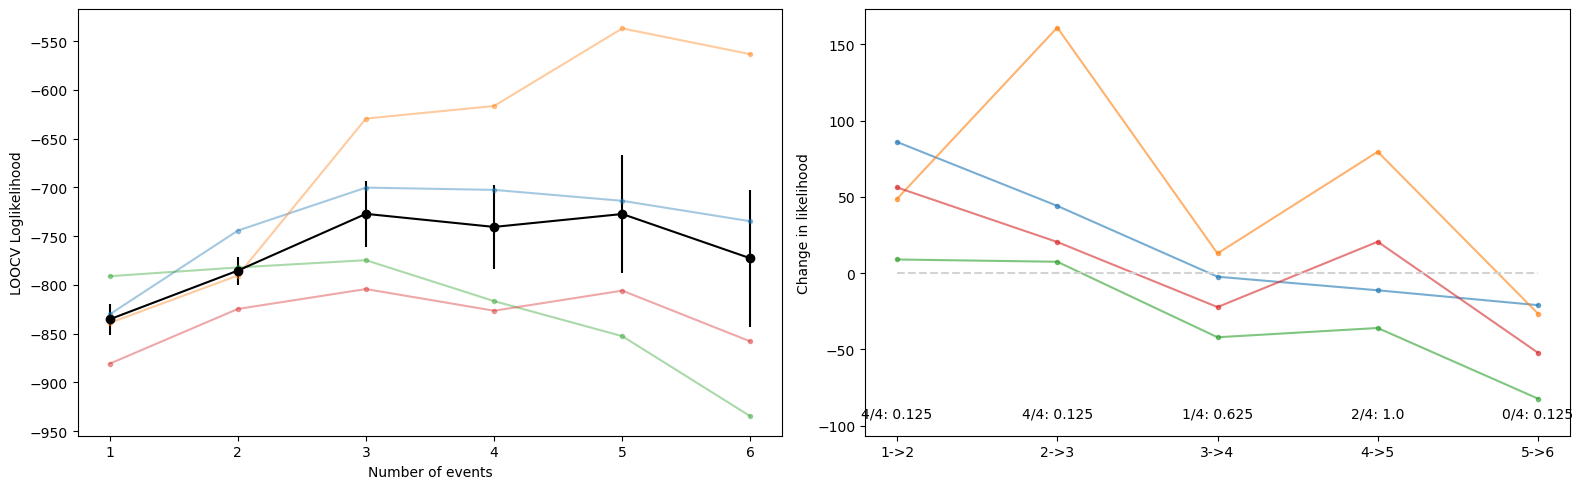

In [13]:
hmp.visu.plot_loocv(loocv_model, pvals=True, test='sign', indiv=True, mean=True) #Colored shaded lines represent individuals

Unlike in the graph above, the loglikelihood increases only up to 3 events, although with 4 participants the results are obviously not to be taken too seriously. The figure on the right contains p-values for sign tests evaluating whether the fit improved for a significant number of subjects, but this cannot be significant with 4 participants. In this case going to 3 events is the best option (see right panel), considering that it has the most events for which a significant number of participants improved (4/4). In normal-sized datasets, one can use the sign-test to see how many events generalize across subjects, and that is also typically done (see also [this paper](https://link.springer.com/article/10.1007/s42113-021-00105-2) for further discussion on this topic).

We can now plot the final model:

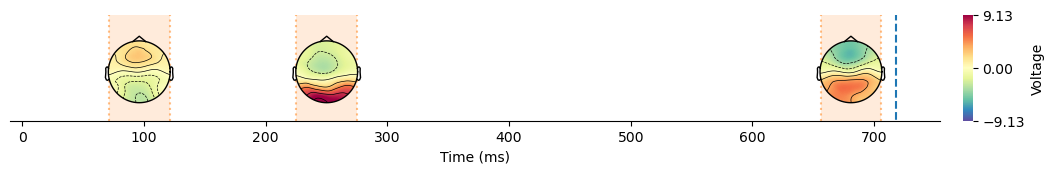

In [14]:
final_model = backward_model.sel(n_events=3)
hmp.visu.plot_topo_timecourse(epoch_data, final_model, info, init, as_time=True)

This method is therefore clearly more conservative than the clustering method (and than the maximal model from `fit`), at least with so few participants.

You might have noticed that the `loocv` method printed a warning saying that it is incorrect. The reason for this is that the input model is used to inform the models fitted to _n-1_ participants, while this input model was based on all participants. Therefore, the calculated loglikelihood of the _nth_ subject is not completely independent of the other participants. We do provide this function, because it a) provides a quick way to estimating rough LOOCV values and b) can be used if you have independent starting points, perhaps from the literature or other studies in your lab.

Of course, we also included a correct method. `loocv_func` will apply a given function (for example, backward estimation) to _n-1_ participants, and then calculate the fit. Unforunately, as in this case we don't have useful starting points it will take much longer to calculate. As we typically do this for backward estimation, we also provide a function specifically for this: `loocv_backward`. In the next tutorial we will illustrate how it can be used in a more complex situation (backward estimation followed by condition-specific models). Both `loocv_func` and `loocv_backward` return a list: the first item contains the loglikelihoods, the second item the fitted models to _n-1_ participants that can be used to construct the final model.

Executing the code below will take quite some time!

Calculating estimates with func <function backward_func at 0x7f54a6252f20> and args [6, 0, 1, 'random', 0.0001, True, 1000.0].
	Estimating model for all participants except processed_0025_epo
Estimating all solutions for maximal number of events (6) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events
	Estimating model for all participants except processed_0023_epo
Estimating all solutions for maximal number of events (6) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events
	Estimating model for

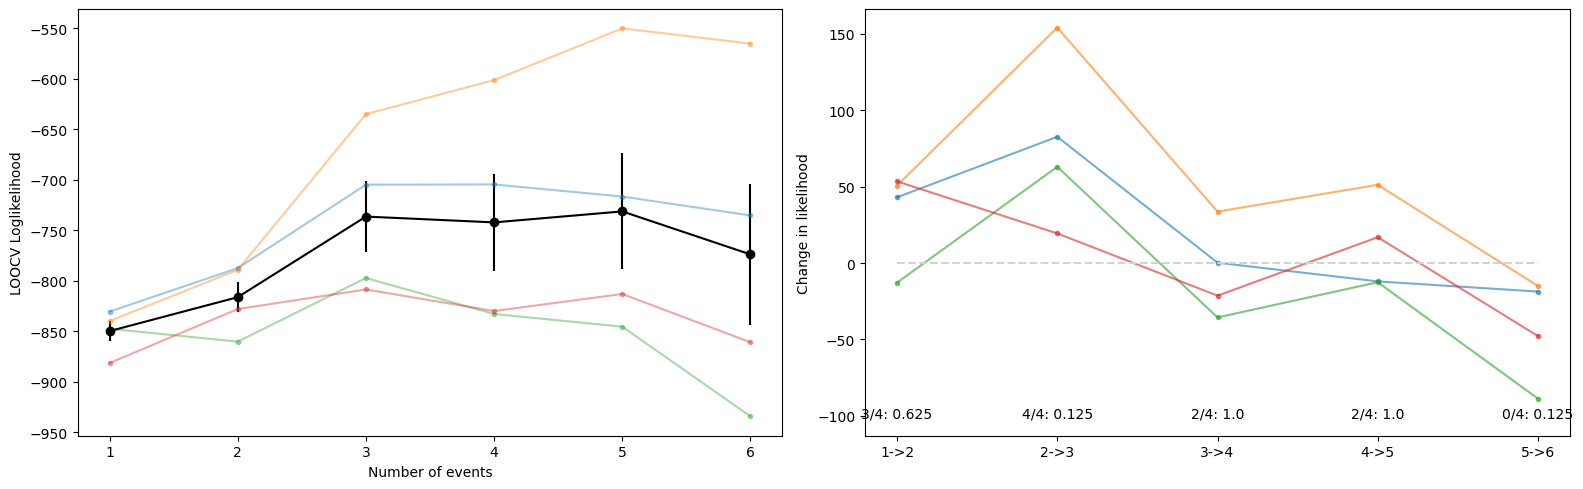

In [15]:
correct_loocv_model = hmp.utils.loocv_backward(init, hmp_data, max_events=6)
hmp.visu.plot_loocv(correct_loocv_model[0], pvals=True, test='sign', indiv=True, mean=True)

Not only are these results correct, but they are also smoother than the ones before. Now, we might go for a four event model, as 3 out of 4 participants still improved. However, we certainly have evidence for 3 events here.

Estimating 3 events model
parameters estimated for 3 events model


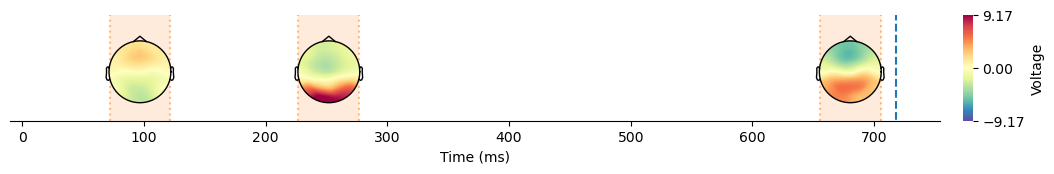

In [16]:
models = correct_loocv_model[1]

#get average mags and params
mags = models[0].sel(n_events=3).dropna('event').magnitudes
params = models[0].sel(n_events=3).dropna('stage').parameters
for pp in range(1,len(np.unique(models[0].participant.values))):
    mags += models[pp].sel(n_events=3).dropna('event').magnitudes
    params += models[pp].sel(n_events=3).dropna('stage').parameters
mags = mags / len(np.unique(models[0].participant.values))
params = params / len(np.unique(models[0].participant.values))

#fit final model
correct_final_model = init.fit_single(3,magnitudes=mags,parameters=params)
hmp.visu.plot_topo_timecourse(epoch_data, correct_final_model, info, init, as_time=True, contours=0)

... which is, as expected, very similar to the one above.

# Bootstrapping

At this point, we are certain that there is evidence in the data for at least three events. As a final step of judging the quality of this solution and estimating variability in the data due to noise and different strategies, for example, we perform bootstrapping. The idea of [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is to test the model on random samples (with replacement) of our data, to make sure that the discovered events are robust.

In the case of EEG data we can bootstrap the epochs/trials of the EEG data. Thus, the analysis consists of three steps that are repeated a number of times:
1. generate a bootstrapped dataset
2. fit a model using `fit_single` in combination with the parameters and magnitudes of the winning LOOCV model
3. record the parameters of the fitted HMP model

With sufficient bootstrapped repetitions we will know wich events tend to be rare (e.g., outliers or different strategies) and what the variance in time and topologies are.

To illustrate, we first run a single repetition:

In [17]:
#use final model as input
bootstrapped = hmp.resample.bootstrapping(fit=final_model, data=epoch_data, 
                                          dim=['epochs','participant'], n_iterations=1,
                                          init=init, cpus=cpus, pca_weights=hmp_data.pca_weights)

  0%|          | 0/1 [00:00<?, ?it/s]

We then compare to the times of the final LOOCV model (the vertical lines in the plot):

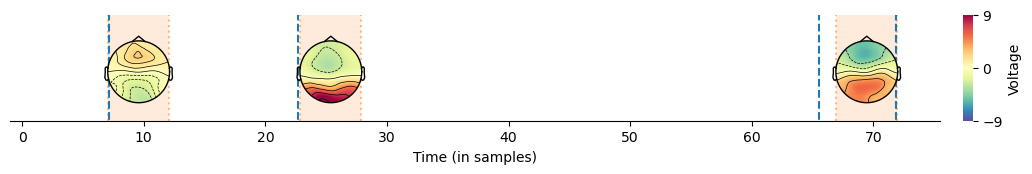

In [18]:
times_general_run = init.compute_times(init, correct_final_model, duration=False, mean=True, add_rt=True)
hmp.visu.plot_topo_timecourse(bootstrapped.sel(iteration=0).channels_activity.values, 
                              bootstrapped.sel(iteration=0).event_times.values,
                              info, init, times_to_display=times_general_run.values)

As you can see, hardly anything changes here. But one bootstrap is not very informative, so let's run 10 of them:

In [19]:
bootstrapped = hmp.resample.bootstrapping(fit=correct_final_model, data=epoch_data, 
                                          dim=['epochs','participant'], n_iterations=10,
                                          init=init, cpus=cpus, pca_weights=hmp_data.pca_weights)

  0%|          | 0/10 [00:00<?, ?it/s]

We can then plot the bootstrapped models

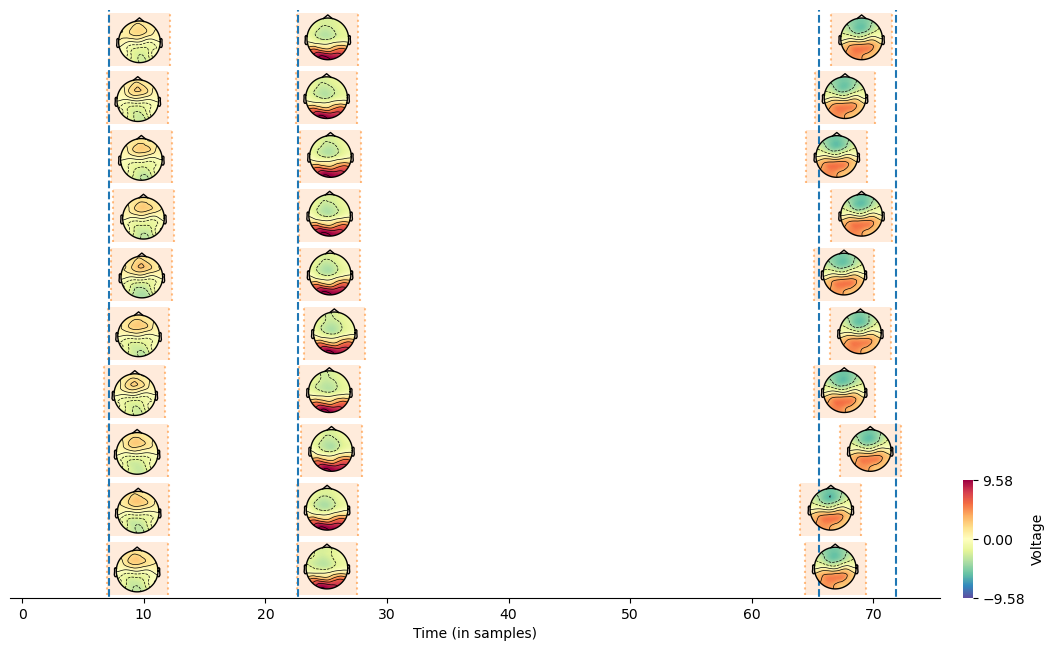

In [20]:
hmp.visu.plot_topo_timecourse(bootstrapped.channels_activity.values, 
                              bootstrapped.event_times.values,
                              info, init, times_to_display=times_general_run.values)

Only the last event shows some variability, this is clearly the hardest one to estimate.

# Tutorial 4

# Condition differences

In the previous tutorials, we have assumed that the same events occur in all conditions of our experiments, and that they can be described by a single model. This is obviously a strong simplication: we typically have different conditions in our experiment to investigate differential effects. In this tutorial we will explore how we can take condition differences into account by:
- having events occur in a subset of the conditions
- varying gamma parameters by condition
- varying magnitudes by condition

In all cases, we also want to judge whether the new models are a better way to account for the data by applying LOOCV. Note that we will use the quick (and incorrect) LOOCV method throughout this tutorial in the interest of speed (but suppress the warning message). At the end we will explain how to do it correctly.

We perform these analyses on the same dataset as in Tutorial 3: a random dot motion task with a speed and an accuracy condition. In addition, sometimes participants had to use their left hands, sometimes their right hand.

First, we load these data and initialize the hmp model:

In [1]:
import os
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
from mne.io import read_info

cpus = 3 #set the number of cores to use for all the code

epoch_data = xr.load_dataset(os.path.join('../sample_data/sample_data.nc'))

#We create also the position array for the electrodes as we are going to need them to plot the event topologies
positions = read_info(os.path.join('../sample_data/eeg/processed_0023_epo.fif'), verbose=False)

#And we transform as in the previous tutorial
hmp_data = hmp.utils.transform_data(epoch_data, apply_zscore='trial', n_comp=4)

init = hmp.models.hmp(hmp_data, epoch_data, event_width=50, cpus=cpus)


## Number of events

If you think there might be different numbers of events in different conditions of your experiment, it is good practice to apply separate backward estimation analyses (including LOOCV) to these conditions. As in the previous tutorial we base the maximum models on the `fit` method. See for details Tutorial 3.

### Speed condition

In [2]:
# select the data
hmp_speed_data = hmp.utils.condition_selection(hmp_data, epoch_data, 'SP', variable='cue') # select the conditions where participants needs to be fast
init_speed = hmp.models.hmp(hmp_speed_data, sfreq=epoch_data.sfreq, cpus=cpus)

  0%|          | 0/53 [00:00<?, ?it/s]

Transition event 1 found around sample 10
Transition event 2 found around sample 15
Transition event 3 found around sample 26
Transition event 4 found around sample 49
Estimating 4 events model
parameters estimated for 4 events model


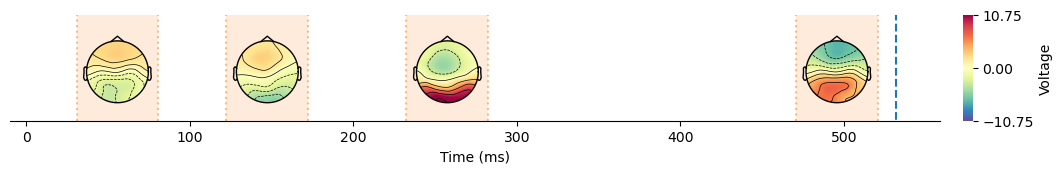

In [3]:
#apply fit function to build maximal model
estimates_speed = init_speed.fit()
hmp.visu.plot_topo_timecourse(epoch_data, estimates_speed, positions, init_speed, as_time=True)

For the speed condition, the `fit` function discovers four events. Next, we apply backward estimation and LOOCV.

Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events


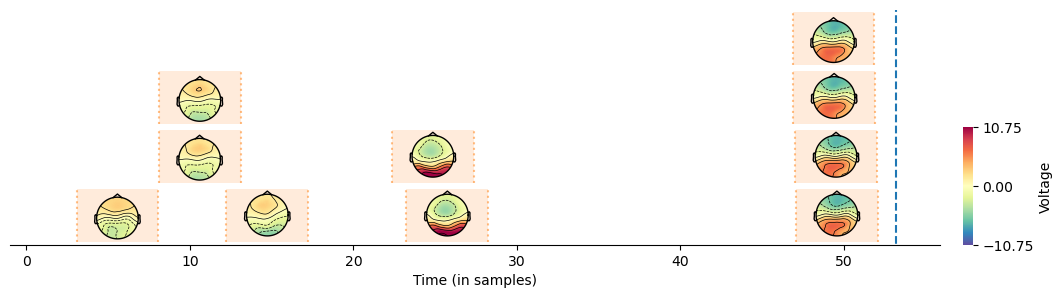

In [4]:
#backward estimation
backward_speed = init_speed.backward_estimation(max_fit=estimates_speed)
hmp.visu.plot_topo_timecourse(epoch_data, backward_speed, positions, init_speed)

LOOCV started for 1 model(s)
	LOOCV for backward estimation models with [4 3 2 1] event(s)
	  Estimating backward estimation model with 4 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo
	  Estimating backward estimation model with 3 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo
	  Estimating backward estimation model with 2 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo
	  Estimating backward estimation model with 1 event(s)
		Calculating fit for participant processed_0025_

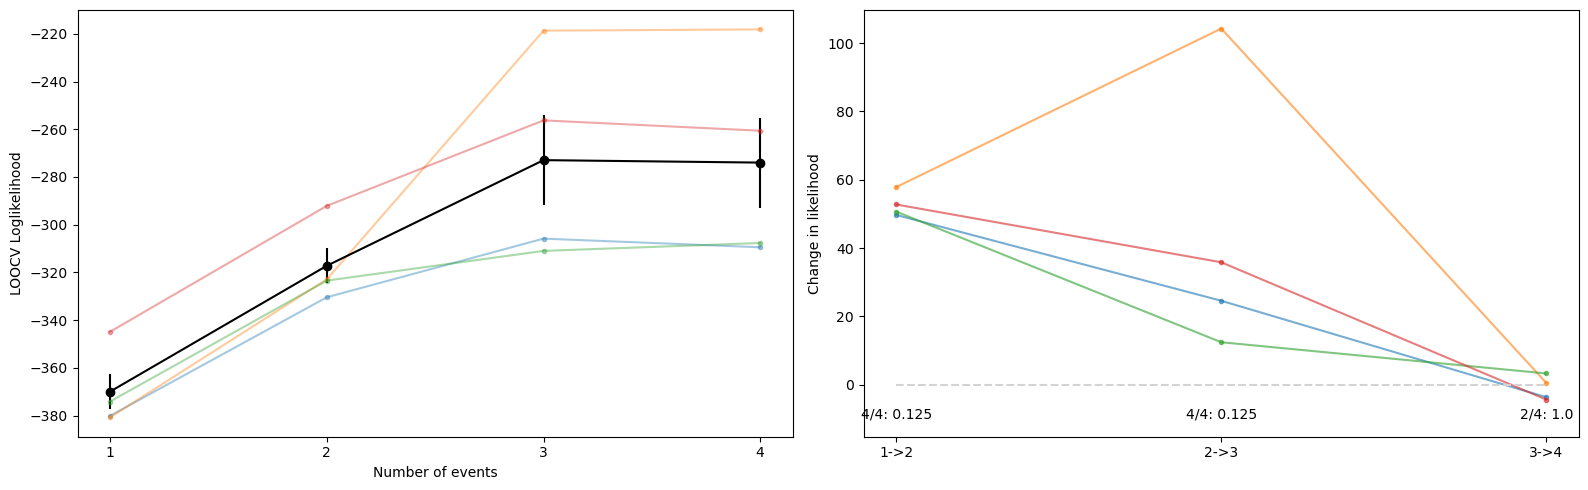

In [5]:
#LOOCV
loocv_model_speed = hmp.utils.loocv(init_speed, hmp_speed_data, backward_speed, print_warning=False)
hmp.visu.plot_loocv(loocv_model_speed, pvals=True, test='sign', indiv=True, mean=True) #Colored shaded lines represent individuals

For the speed condition, we find clear evidence for three events, and some evidence for four. In the interest of the demonstration in this tutorial we will go with three events here, and four events for the accuracy condition, as explained in the next section.

### Accuracy condition

We repeat the same analysis for the accuracy condition.

In [6]:
# select the data
hmp_accuracy_data = hmp.utils.condition_selection(hmp_data, epoch_data, 'AC', variable='cue') # select the conditions where participants needs to be accurate
init_accuracy = hmp.models.hmp(hmp_accuracy_data, sfreq=epoch_data.sfreq, cpus=cpus)

  0%|          | 0/90 [00:00<?, ?it/s]

Transition event 1 found around sample 10
Transition event 2 found around sample 26
Transition event 3 found around sample 32
Transition event 4 found around sample 44
Transition event 5 found around sample 57
Transition event 6 found around sample 59
Transition event 7 found around sample 61
Transition event 8 found around sample 62
Transition event 9 found around sample 86
Estimating 9 events model
parameters estimated for 9 events model


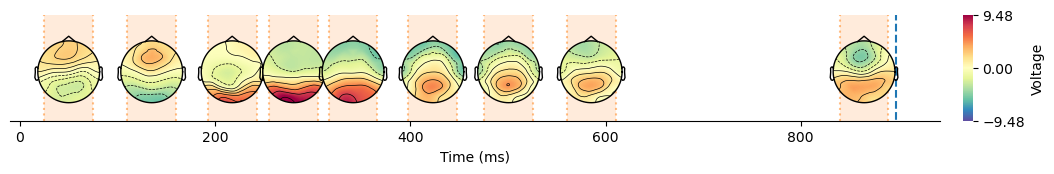

In [7]:
#apply fit function to build maximal model
estimates_accuracy = init_accuracy.fit()
hmp.visu.plot_topo_timecourse(epoch_data, estimates_accuracy, positions, init_accuracy, as_time=True)

For the accuracy condition, many more events are discovered: 9 instead of 4, with quite a number of 'copies'. To determine how many events are 'real', we once again perform backward estimation and LOOCV.

Estimating all solutions for 8 number of events
Estimating all solutions for 7 number of events
Estimating all solutions for 6 number of events
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events


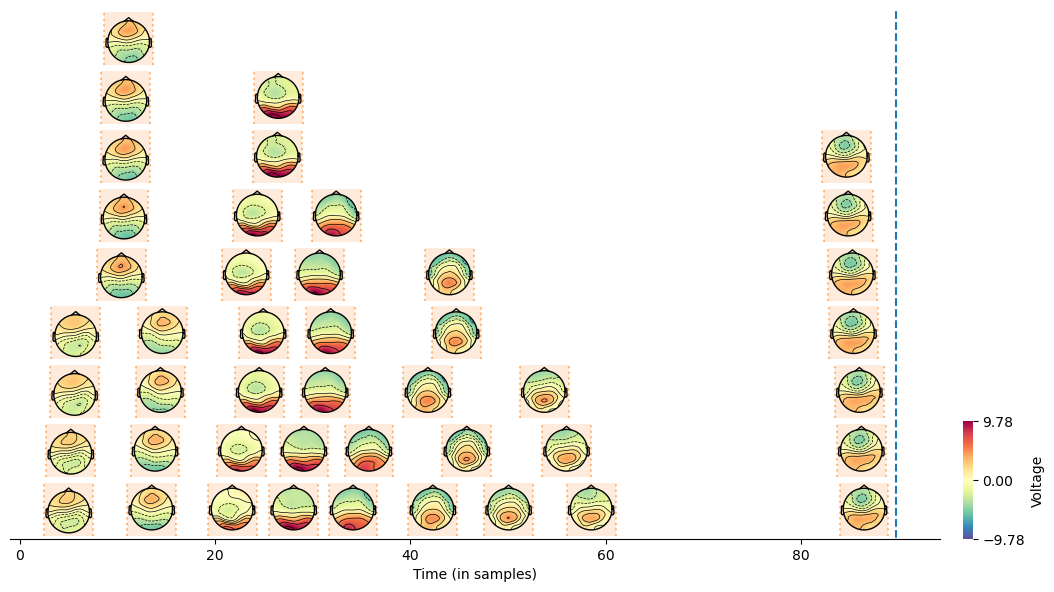

LOOCV started for 1 model(s)
	LOOCV for backward estimation models with [9 8 7 6 5 4 3 2 1] event(s)
	  Estimating backward estimation model with 9 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo
	  Estimating backward estimation model with 8 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo
	  Estimating backward estimation model with 7 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo
	  Estimating backward estimation model with 6 event(s)
		Calculating fit for participant proce

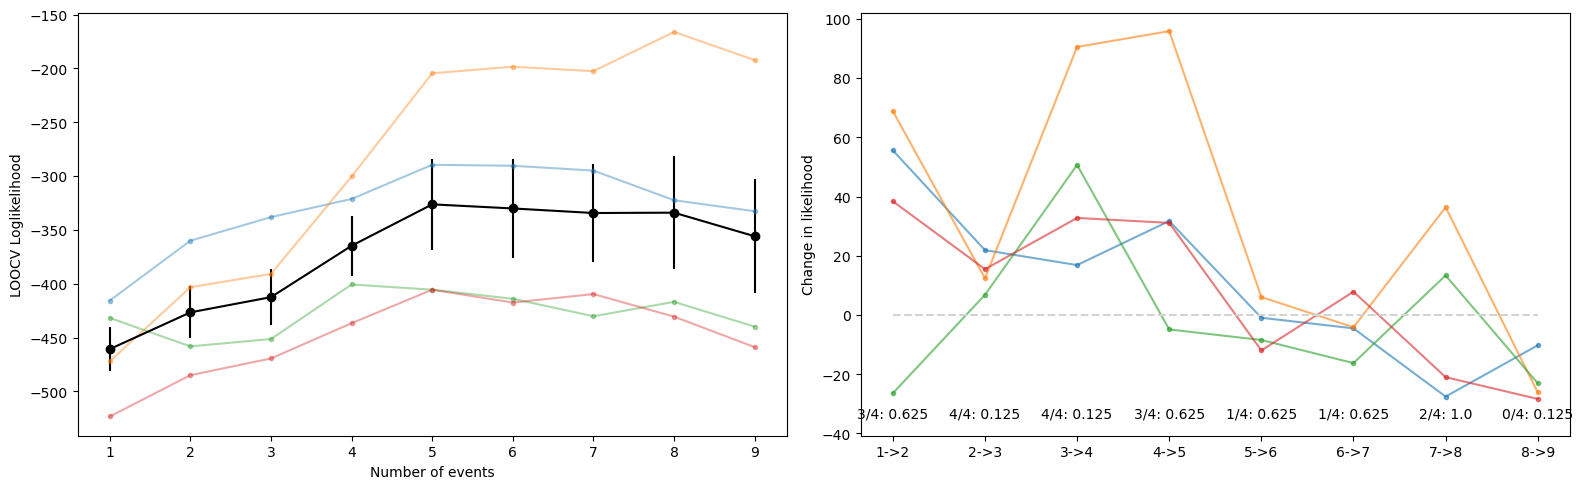

In [8]:
#backward estimation
backward_accuracy = init_accuracy.backward_estimation(max_fit=estimates_accuracy)
hmp.visu.plot_topo_timecourse(epoch_data, backward_accuracy, positions, init_accuracy)

#LOOCV
loocv_model_accuracy = hmp.utils.loocv(init_accuracy, hmp_accuracy_data, backward_accuracy, print_warning=False)
hmp.visu.plot_loocv(loocv_model_accuracy, pvals=True, test='sign', indiv=True, mean=True) 

The LOOCV results show that we have evidence for 4 or 5 events; with more events at most 2 participants still improve. For demonstration purposes we will go with 4 events in this case.

Let's plot the two winning models together:

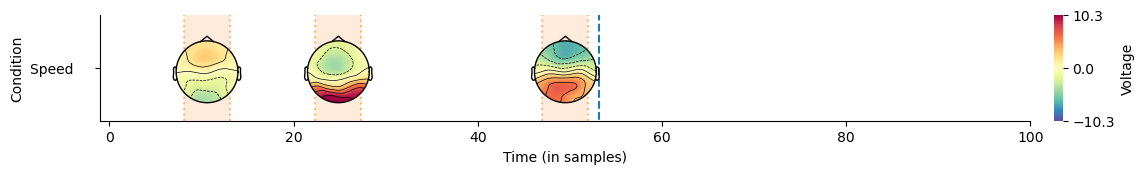

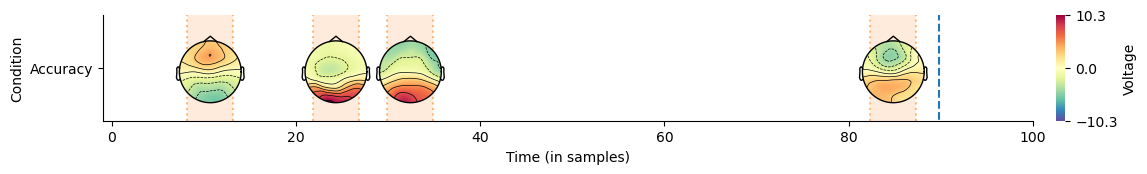

In [9]:
for condition in zip([backward_speed.sel(n_events=3), backward_accuracy.sel(n_events=4)],
                     [init_speed, init_accuracy],
                     [hmp_speed_data, hmp_accuracy_data],
                    ['Speed    ', 'Accuracy']):
    hmp.visu.plot_topo_timecourse(epoch_data, condition[0],
                          positions, condition[1],  
                          max_time=100,
                          ylabels={'Condition':[condition[3]]},vmin=-10.3,vmax=10.3)

Looking at the toplogies and time courses suggest that these models share the first, second, and last events, and that the Accuracy model has an extra intervening event.

### Combining speed and accuracy

Given this conclusion, we would like to combine these models, to see if we can have a comparable fit while using fewer parameters. To that, we will use `fit_single_conds`. For this we need to specify maps for the events and for the stages indicating which events appear in both models. These maps have rows for the conditions and columns for the events/stages. When the maps have negative values, this indicates missing events. In addition, we need to specify the condition we want to analyze on the full dataset. Let's looks at how we would define the combined speed-accuracy model:

In [10]:
# the magnitudes map indicates the events. We have two conditions, speed and accuracy, hence two rows. For speed the third event is missing, indicated by the -1.
mags_map = np.array([[0, 0, -1, 0],
                     [0, 0, 0, 0]])

# the parameters maps indicates the stages. Here, we indicate that stage 3 is missing for the speed condition. Obviously, this has to be congruent with magnitudes map.
pars_map = np.array([[0, 0, -1, 0, 0],
                     [0, 0, 0, 0, 0]])

# finally, we have to define the conditions we want to analyze:
conds = {'cue': ['SP', 'AC']} #dictionary with conditions to analyze as well as the levels.

Next we are going to fit the combined model, as starting parameter we use the four-event accuracy model (note that you could also first fit the best possible combined 4-stage, for example).

Condition "cue" analyzed, with levels: ['SP', 'AC']

Coded as follows: 
0: ['SP']
1: ['AC']

Magnitudes map:
0:  [ 0  0 -1  0]
1:  [0 0 0 0]

Parameters map:
0:  [ 0  0 -1  0  0]
1:  [0 0 0 0 0]

-----
Negative parameters. Note that this stage is left out, while the parameters
of the other stages are compared column by column. In this parameter map example:
[[ 0  0  0  0]
 [ 0 -1  0  0]]
the parameters of stage 1 are shared, as well as the parameters of stage 3 of
condition 1 with stage 2 (column 3) of condition 2 and the last stage of both
conditions.
Given that event 2 is probably missing in condition 2, it would typically
make more sense to let both stages around event 2 in condition 1 vary as
compared to condition 2:
[[ 0  0  0  0]
 [ 0 -1  1  0]]
-----

Estimating 4 events model
parameters estimated for 4 events model


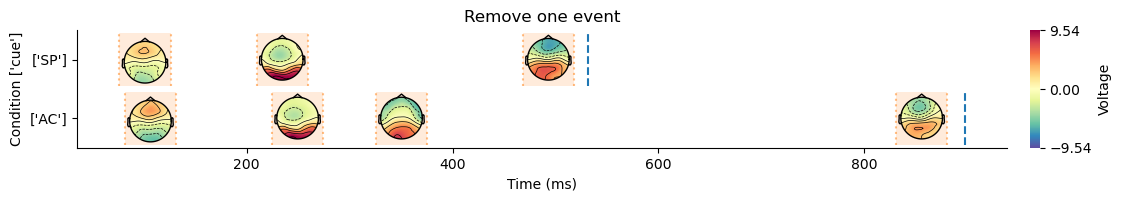

In [11]:
# we take the starting parameters from the accuracy model (you could also take the average)
mags4 = backward_accuracy.sel(n_events=4).dropna('event').magnitudes.data
pars4 = backward_accuracy.sel(n_events=4).dropna('stage').parameters.data

#fit the model - note that we use the full data again
model_stage_removed = init.fit_single_conds(magnitudes=mags4, parameters=pars4, pars_map=pars_map, mags_map=mags_map, conds=conds)
hmp.visu.plot_topo_timecourse(epoch_data, model_stage_removed, positions, init, magnify=1, sensors=False, time_step=1000/init.sfreq,xlabel='Time (ms)', event_lines=True, colorbar=True, title="Remove one event") 


It is useful to check whether the rows of the maps correspond to the right conditions in the output of the function.

As we can see, we get the combined model that we expected. Given that this model has much fewer parameters (it estimates four topologies instead of seven), it is probably preferred over the original two models that we had. We can test this using LOOCV. We will apply LOOCV to the combined model and to the two separate models. If the added loglikelihood of the two separate models is not higher for a significant number of participants than the loglikelihood of the combined model, we prefer the combined model as it has fewer parameters.

Note that the code below takes a while to run; his can also be skipped for now.

In [12]:
loocv_speed = hmp.utils.loocv(init_speed,hmp_speed_data, backward_speed.sel(n_events=3).dropna('event'), print_warning=False)
loocv_accuracy = hmp.utils.loocv(init_accuracy,hmp_accuracy_data, backward_accuracy.sel(n_events=4).dropna('event'), print_warning=False)
loocv_combined = hmp.utils.loocv(init, hmp_data, model_stage_removed, print_warning=False)

LOOCV started for 1 model(s)
	LOOCV for single model with 3 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo
LOOCV started for 1 model(s)
	LOOCV for single model with 4 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo
LOOCV started for 1 model(s)
	LOOCV for condition-based model with 4 event(s)
		Calculating fit for participant processed_0025_epo
		Calculating fit for participant processed_0023_epo
		Calculating fit for participant processed_0024_epo
		Calculating fit for participant processed_0022_epo


In [13]:
#sum likelihoods of speed and accuracy, this is possible as long as the datasets are completely independent
loocv_separate_models = loocv_speed.values + loocv_accuracy.values

#compare to the combined model
difference = loocv_combined - loocv_separate_models

print(difference.values)
print(np.sum(difference > 0))

[ 58.67800116 143.09551096  10.49350123 -25.48803387]
<xarray.DataArray 'loo_likelihood' ()>
array(3)


So, the combined model has a greater loglikelihood than the separate models for three of the four participants, even though the latter ones have way more freedom to fit the data. Here, we clearly prefer the combined model.

## Different stage durations

If we look at the combined model, it seems that the duration of the penultimate stage should be modeled with different parameters for speed than for accuracy:

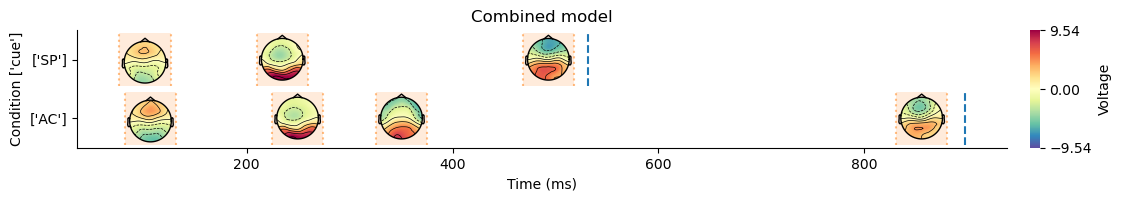

In [15]:
hmp.visu.plot_topo_timecourse(epoch_data, model_stage_removed, positions, init, magnify=1, sensors=False, time_step=1000/init.sfreq,xlabel='Time (ms)', event_lines=True, colorbar=True, title="Combined model") 

Fortunately, we can easily do that by changing the 'parameter map'. If we use different numbers for different conditions, we can indicate that the model is allowed to use different parameters for that stage.

Condition "cue" analyzed, with levels: ['SP', 'AC']

Coded as follows: 
0: ['SP']
1: ['AC']

Magnitudes map:
0:  [ 0  0 -1  0]
1:  [0 0 0 0]

Parameters map:
0:  [ 0  0 -1  0  0]
1:  [0 0 0 1 0]

-----
Negative parameters. Note that this stage is left out, while the parameters
of the other stages are compared column by column. In this parameter map example:
[[ 0  0  0  0]
 [ 0 -1  0  0]]
the parameters of stage 1 are shared, as well as the parameters of stage 3 of
condition 1 with stage 2 (column 3) of condition 2 and the last stage of both
conditions.
Given that event 2 is probably missing in condition 2, it would typically
make more sense to let both stages around event 2 in condition 1 vary as
compared to condition 2:
[[ 0  0  0  0]
 [ 0 -1  1  0]]
-----

Estimating 4 events model
parameters estimated for 4 events model


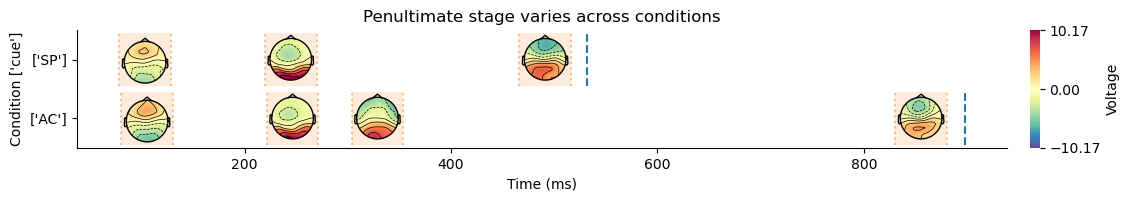

In [16]:
# the same as above: for speed the third event is missing, indicated by the -1.
mags_map = np.array([[0, 0, -1, 0],
                     [0, 0, 0, 0]])

# here we make a change, we now allow the penultimate stage to vary between conditions, indicated by the one in the second row
pars_map = np.array([[0, 0, -1, 0, 0],
                     [0, 0, 0, 1, 0]])

#unchanged from above
conds = {'cue': ['SP', 'AC']} 
mags4 = backward_accuracy.sel(n_events=4).dropna('event').magnitudes.data
pars4 = backward_accuracy.sel(n_events=4).dropna('stage').parameters.data

#fit the model 
model_different_stage = init.fit_single_conds(magnitudes=mags4, parameters=pars4, pars_map=pars_map, mags_map=mags_map, conds=conds)
hmp.visu.plot_topo_timecourse(epoch_data, model_different_stage, positions, init, magnify=1, sensors=False, time_step=1000/init.sfreq,xlabel='Time (ms)', event_lines=True, colorbar=True, title="Penultimate stage varies across conditions") 


As you can see this leads to the first events lining up better between the conditions. If we just look at the overall log-likelihood, we indeed see that it might explain the data better:

In [17]:
print('likelihood with different stage duration:' + str(model_different_stage.likelihoods.values))
print('likelihood first combined model:' + str(model_stage_removed.likelihoods.values))

likelihood with different stage duration:-1728.4023030667252
likelihood first combined model:-1819.2435857294006


## Different topologies

There was a second manipulation in this experiment: right vs. left hand. This should results in a different topology of the last event, which is probably associated with the response. It won't surprise you at this point that we can test this by specifying this in the magnitudes map. We now take all data again and fit four events, use the left and right response conditions, and let the last topology vary.

Condition "resp" analyzed, with levels: ['resp_left', 'resp_right']

Coded as follows: 
0: ['resp_left']
1: ['resp_right']

Magnitudes map:
0:  [0 0 0 0]
1:  [0 0 0 1]

Parameters map:
0:  [0 0 0 0 0]
1:  [0 0 0 0 0]

Estimating 4 events model
parameters estimated for 4 events model


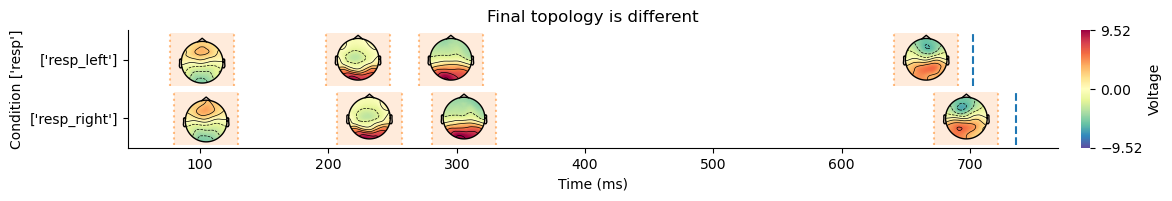

In [19]:
# Both condition have four stages this time, but the last topology can differ:
mags_map = np.array([[0, 0, 0, 0],
                     [0, 0, 0, 1]])

# As we now share all parameters, you don't have to specify them:
pars_map = None

# As condition we use the response hand
conds = {'resp': ['resp_left', 'resp_right']}

# we just take the accuracy model parameters as starting points
mags4 = backward_accuracy.sel(n_events=4).dropna('event').magnitudes.data
pars4 = backward_accuracy.sel(n_events=4).dropna('stage').parameters.data

#fit the model 
model_different_topologies = init.fit_single_conds(magnitudes=mags4, parameters=pars4, pars_map=pars_map, mags_map=mags_map, conds=conds)
hmp.visu.plot_topo_timecourse(epoch_data, model_different_topologies, positions, init, magnify=1, sensors=False, time_step=1000/init.sfreq,xlabel='Time (ms)', event_lines=True, colorbar=True, title="Final topology is different")

What you see is that left responses are right lateralized, and right responses left lateralized, exactly as you would expect. Again, you can use LOOCV to test this model.

## Correct LOOCV

In the code above we used the fast LOOCV procedure, which is incorrect but convenient for exploring your data. If you want to do these analyses correctly, you will have to use `loocv_func` and specify the funcion that you want to apply to your data. This function can also return multiple models which are then all used for LOOCV. Given that this can be rather complex, we provide an example function here:

In [20]:
def backward_and_conds(hmp_model):
       
    #fit backward model up to max_events
    backward_model = hmp_model.backward_estimation(max_events=6)

    #select 4 events model
    four_model = backward_model.sel(n_events=4).dropna('event')
    mags = four_model.magnitudes.dropna('event').data
    pars = four_model.parameters.dropna('stage').data

    #specify conditions
    mags_map = np.array([[0, 0, -1, 0],
                         [0, 0, 0, 0]])
    pars_map = np.array([[0, 0, -1, 0, 0],
                         [0, 0, 0, 0, 0]])
    conds = {'cue': ['SP', 'AC']} 

    #fit condition model
    cond_model = hmp_model.fit_single_conds(magnitudes=mags, parameters=pars, mags_map=mags_map, pars_map=pars_map, conds=conds, verbose=False)
    
    return [backward_model, cond_model]

This function expect an hmp_model as input, and returns one or more models - in this case two: a backward model and one condition-based model. It fits the first condition-based model that we estimated above.

We can use this function as follows, but note that it takes significant time to run, even with four participants!

In [21]:
loocv_back_conds = hmp.utils.loocv_func(init, hmp_data, backward_and_conds,func_args=[])

Calculating estimates with func <function backward_and_conds at 0x7f5eb72028e0> and args [].
	Estimating model for all participants except processed_0025_epo
Estimating all solutions for maximal number of events (6) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events
	Estimating model for all participants except processed_0023_epo
Estimating all solutions for maximal number of events (6) with 1 pre-defined starting point and 0 random starting points
Estimating all solutions for 5 number of events
Estimating all solutions for 4 number of events
Estimating all solutions for 3 number of events
Estimating all solutions for 2 number of events
Estimating all solutions for 1 number of events
	Estimating model for all participants except processed

As you can see, you could also build an even more complex function that takes input arguments provided by `func_args`.

We can plot the results, in this case plotting the fit of the combined model between the 3 and 4 stage models of backward estimation.

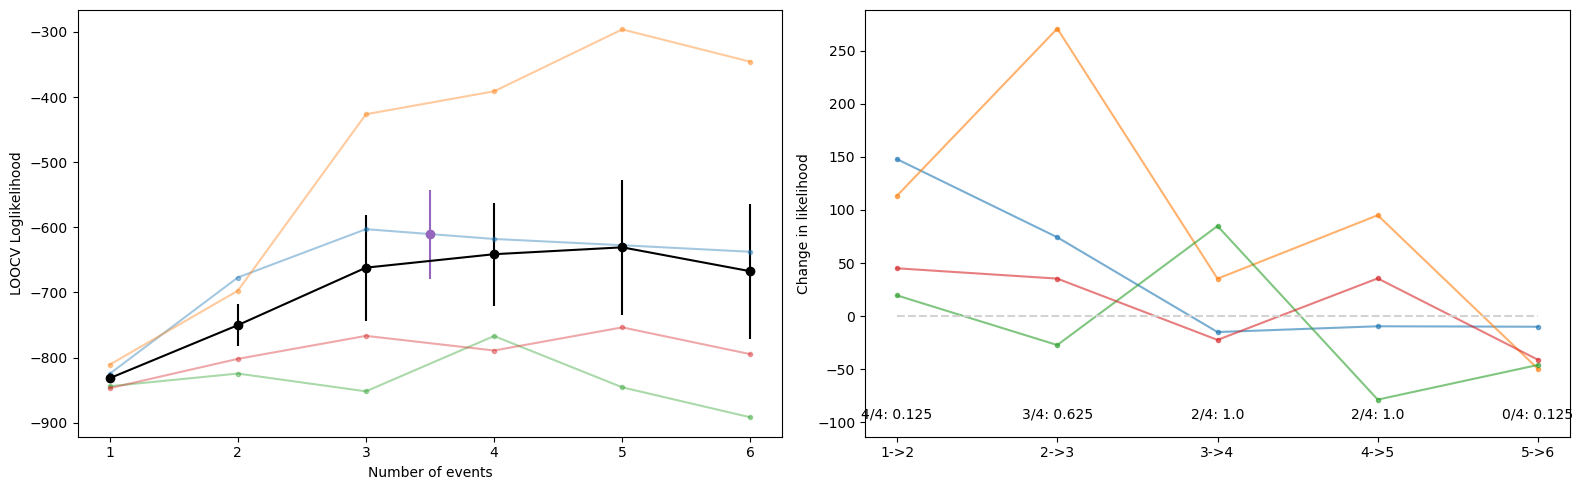

In [22]:
#specify combined model as additional point
hmp.visu.plot_loocv(loocv_back_conds[0][0], pvals=True, test='sign', indiv=True, mean=True, additional_points = (3.5, loocv_back_conds[0][1]))

The combined model (purple dot) seems to outperform the backward-estimated models. We can also test that directly, here comparing to the four-event model:

In [23]:
loocv_back_conds[0][1].values - loocv_back_conds[0][0].sel(n_event=4).values

array([-13.32262532,   8.54417771,  65.30021889,  61.57723751])

For three out of four participants, the combined model is better.

In this tutorial, we explored the effects of different conditions. First we build a combined model that better explains the data than two separate models, even though it has way fewer parameters. Next, we made this model more complex by allowing stage distributions and/or topologies to vary across conditions. This is also how approach real datasets, where we continue this process until the LOOCV indicates that a more complex does not outperform the simple model.